In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sqlalchemy import create_engine, Engine
from matplotlib import pyplot as plt
from typing import Optional
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import phik

from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import warnings

from json import loads

sns.set_style('darkgrid')

In [5]:
ENGINE = create_engine('sqlite:///data/ds-plus-final.db')
TABLE_NAME = ['contract', 'personal', 'internet', 'phone']
RANDOM_STATE = 171224

GSCV_LOG_REGRESSION_CONFIG = {
    'C': [.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', 'elasticnet'],
}
GSCV_RAND_FOREST_CONFIG = {
    'max_depth': range(1, 6),
    'n_estimators': range(1, 202, 10),
}
GSCV_CAT_BOOSRT_CONFIG = {
    'learning_rate':[.1, .5, .8],
    'max_depth': range(1, 6),
    'n_estimators': range(50, 301, 50),
}
IS_SELECTION_PARAMETERS = False # Проводить ли заново подбор лучших параметров моделей
IS_LOCAL = True # Проект выполняется локально

## Первичный анализ и подготовка данных

In [6]:
def get_table_and_display_info(table_names: list[str], engine: Engine) -> list[pd.DataFrame]:
    result = list()
    for table in table_names:
        df = pd.read_sql(f'select * from {table}', engine)
        print('-' * 50)
        print(f'Table - {table}')
        print('-' * 50)
        df.info()
        display(df.head())
        result.append(df)
    return result

In [7]:
contract, personal, internet, phone = get_table_and_display_info(TABLE_NAME, ENGINE)

--------------------------------------------------
Table - contract
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


--------------------------------------------------
Table - personal
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


--------------------------------------------------
Table - internet
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


--------------------------------------------------
Table - phone
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Таблица `contract` содержит информацию о договорах. Таблица содержит 7043 записи. Пропусков нет. Столбцы `Type` (тип оплаты: раз в год-два или ежемесячно), `PaperlessBilling` (электронный расчётный лист), `PaymentMethod` (тип платежа) являются категориальными. Столбцы `MonthlyCharges` (расходы за месяц), `TotalCharges` (расходы за месяц) - количественными и должны быть приведены к типу `float`. Столбцы `BeginDate` (дата начала действия договора), `EndDate` (дата окончания действия договора) не могут использоваться в сыром виде. Должны быть приведеты к типу `datetime`. Для этого в столбце `EndDate` заменим все значения `No` на `None`. Из столбца `EndDate` будет формироваться целевая переменная. 
  
Таблица `personal` содержит информацию о клиентах. Таблица содержит 7043 записи. Пропусков нет. Все признаки являюстся категориальными. В столбце `SeniorCitizen` заменим значение 0 на no и 1 на yes.

Таблица `internet` содержит информацию о подключенных услушах интернета. Таблица содержит 5517 записей. Пропусков нет. Все признаки являются категориальными.

Таблица `phone` содержит информацию о подключенных услугах телефонии. Таблица содержит 6361 записей. Пропусков нет. Все признаки являются категориальными.

Во всех таблицах переименуем столбцы по camelCase. Также можно заметить, что во всех таблицах все стобцы автоматически загружаются как строковые. Для дальнейшей работы сразу проведем предобработку: приведем строки к ниждему регистру и удалим лишние пробелы.

Переведем столбцы во все таблицах в camelCase. Также все столбцы, кроме ID пользователей, с категориальными признаками переведем в тип `category`.

### Предобработка таблицы Договоры

Переименуем столбцы

In [8]:
contract.rename(columns={
    'customerID': 'customerId',
    'BeginDate': 'beginDate',
    'EndDate': 'endDate',
    'Type': 'type',
    'PaperlessBilling': 'paperlessBilling',
    'PaymentMethod': 'paymentMethod',
    'MonthlyCharges': 'monthlyCharges',
    'TotalCharges': 'totalCharges'
}, inplace=True)

Выполним предобработку всех столбцов, кроме ID пользователя

In [9]:
contract.loc[:, contract.columns != 'customerId'] = contract.loc[:,contract.columns!='customerId'].map(lambda x: ' '.join(x.lower().split()))

Выполним приведение типов столбцов

In [10]:
contract['endDate'] = contract['endDate'].replace({'no': None})
contract = contract.replace({'': None})

In [11]:
contract = contract.astype({
    'type': 'category',
    'paperlessBilling': 'category',
    'paymentMethod': 'category',
    'monthlyCharges': 'float',
    'totalCharges': 'float',
})
contract['beginDate'] = pd.to_datetime(contract['beginDate'], format='%Y-%m-%d')
contract['endDate'] = pd.to_datetime(contract['endDate'], format='%Y-%m-%d')

In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerId        7043 non-null   object        
 1   beginDate         7043 non-null   datetime64[ns]
 2   endDate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   category      
 4   paperlessBilling  7043 non-null   category      
 5   paymentMethod     7043 non-null   category      
 6   monthlyCharges    7043 non-null   float64       
 7   totalCharges      7032 non-null   float64       
dtypes: category(3), datetime64[ns](2), float64(2), object(1)
memory usage: 296.3+ KB


Можно заметить, что после предобработки в таблице с договорами появились пропуски в столбцах `endDate` и `totalCharges`

### Предобработка таблицы Пользователи

In [13]:
personal.rename(columns={
    'customerID': 'customerId',
    'SeniorCitizen': 'seniorCitizen',
    'Partner': 'partner',
    'Dependents': 'dependents'
}, inplace=True)

Выполним предобработку всех столбцов, кроме ID пользователя

In [14]:
personal.loc[:, personal.columns != 'customerId'] = personal.loc[:,personal.columns!='customerId'].map(lambda x: ' '.join(x.lower().split()))

Выполним приведение типов столбцов

In [15]:
personal = personal.replace({'': None})
personal['seniorCitizen'] = personal['seniorCitizen'].replace({'0': 'no', '1': 'yes'})

In [16]:
personal = personal.astype({
    'gender': 'category',
    'seniorCitizen': 'category',
    'partner': 'category',
    'dependents': 'category',
})

In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerId     7043 non-null   object  
 1   gender         7043 non-null   category
 2   seniorCitizen  7043 non-null   category
 3   partner        7043 non-null   category
 4   dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


### Предобработка таблицы Интернет

In [18]:
internet.rename(columns={
    'customerID': 'customerId',
    'InternetService': 'internetService',
    'OnlineSecurity': 'onlineSecurity',
    'OnlineBackup': 'onlineBackup',
    'DeviceProtection': 'deviceProtection',
    'TechSupport': 'techSupport',
    'StreamingTV': 'streamingTV',
    'StreamingMovies': 'streamingMovies'
}, inplace=True)

Выполним предобработку всех столбцов, кроме ID пользователя

In [19]:
internet.loc[:, internet.columns != 'customerId'] = internet.loc[:, internet.columns!='customerId'].map(lambda x: ' '.join(x.lower().split()))

Выполним приведение типов столбцов

In [20]:
internet = internet.replace({'': None})

In [21]:
internet = internet.astype({
    'internetService': 'category',
    'onlineSecurity': 'category',
    'onlineBackup': 'category',
    'deviceProtection': 'category',
    'techSupport': 'category',
    'streamingTV': 'category',
    'streamingMovies': 'category'
})

In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerId        5517 non-null   object  
 1   internetService   5517 non-null   category
 2   onlineSecurity    5517 non-null   category
 3   onlineBackup      5517 non-null   category
 4   deviceProtection  5517 non-null   category
 5   techSupport       5517 non-null   category
 6   streamingTV       5517 non-null   category
 7   streamingMovies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.8+ KB


### Предобработка таблицы Телефон

In [23]:
phone.rename(columns={
    'CustomerId': 'customerId',
    'MultipleLines': 'multipleLines'
}, inplace=True)

Выполним предобработку всех столбцов, кроме ID пользователя

In [24]:
phone.loc[:, phone.columns != 'customerId'] = phone.loc[:, phone.columns!='customerId'].map(lambda x: ' '.join(x.lower().split()))

Выполним приведение типов столбцов

In [25]:
phone = phone.replace({'': None})

In [26]:
phone = phone.astype({
    'multipleLines': 'category',
})

In [27]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerId     6361 non-null   object  
 1   multipleLines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.2+ KB


**Вывод:**  
В рамках предобработки данных был выполнен первоначальный анализ данных. Также выполнено приведение всех категориальных признаков к типу `category`, а значение приведены к нижнему регистру и удалены лишние пробелы. Имен столбцов приведены в camelCase.

## EDA Каждой таблицы в отдельности

In [28]:
def add_annotate_bar(ax):
    for rect in ax.patches:
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = rect.get_width()

        ax.annotate(
            f'{x_value:.3f}',
            (x_value, y_value),
            xytext=(3, 0),
            textcoords="offset points",
            ha='left',
            va='bottom')

In [29]:
def create_heatmap(df: pd.DataFrame, title: Optional[str] = '') -> None:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    ax.grid(False)
    ax.tick_params('x', labelrotation=45)
    sns.heatmap(
        df,
        annot=True, fmt='.2f', ax=ax, square=True,
        annot_kws={'size': 8},
        mask=np.triu(np.ones_like(df, dtype=bool))
    )
    plt.show();

In [30]:
def get_percentage_emissions(data: pd.Series) -> float:
    distr_iqr = data.quantile(.75) - data.quantile(.25)

    upp = data.quantile(.75) + 1.5 * distr_iqr
    low = data.quantile(.25) - 1.5 * distr_iqr

    if upp > data.max():
        upp = data.max()
    if low < data.min():
        low = data.min()

    count_emissions = data[data > upp].count() + data[data < low].count()
    percentage_emissions = count_emissions / len(data)
    
    return percentage_emissions

In [31]:
def cramers_V(var1: pd.Series, var2: pd.Series) :
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return np.sqrt(stat / (obs * mini))

In [32]:
def get_cramers_corr(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    category_columns = df.select_dtypes(include='category')
    for var1 in category_columns:
        col = []
        for var2 in category_columns:
            cramers =cramers_V(category_columns[var1], category_columns[var2])
            col.append(round(cramers,2))
        rows.append(col)
    return pd.DataFrame(np.array(rows), columns=category_columns.columns, index=category_columns.columns)

In [33]:
def create_number_eda(
    df: pd.DataFrame,
    target: Optional[str] = None
) -> None:
    print('Количественные признаки')
    print('-' * 20)
    columns_number = df.select_dtypes(include='number').columns
    if len(columns_number) > 0:
        print('Описательная статистика')
        display(df[columns_number].describe().T)
        for column in columns_number:
            fig = plt.figure(figsize=(12,8))
            percentage_emissions = get_percentage_emissions(df[column])
            fig.suptitle(
                f'Признак "{column}"\nПроцент аномальных значений: {percentage_emissions:.2%}',
                fontsize=16, fontweight='bold'
            )
            ax_1 = fig.add_subplot(2,1,1)
            sns.histplot(df, x=column, multiple='stack', ax=ax_1, hue=target)
            ax_1.set_title('Гистограмма')

            ax_2 = fig.add_subplot(2,1,2)
            sns.boxplot(df, x=column, ax=ax_2)
            ax_2.set_title('Диаграмма размаха')
            plt.tight_layout()
            plt.show();
        print('Корреляция Пирсона для числовых признаков')
        if len(columns_number) > 1:
            corr_pearson = df[columns_number].corr()
            create_heatmap(corr_pearson, 'Коэффициент корреляции Пирсона для числовых признаков')
        else:
            print(('Невозможно построить Матрицу корреляции Пирсона для числовых признаков, '
                   'так как в таблице только 1 числовой признак'))
            
    else:
        print('В таблице нет количественных признаков\n')

In [34]:
def create_category_eda(
    df: pd.DataFrame,
    target: Optional[str] = None
) -> None:
    print('\nКатегориальные признаки')
    print('-' * 20)
    columns_category = df.select_dtypes(include='category').columns
    if len(columns_category) > 0:
        for column in df.select_dtypes(include='category').columns:
            if column != target:
                count_graphs = 2 if target else 1
                
                fig = plt.figure(figsize=(12, 4 * count_graphs))
                ax_1 = fig.add_subplot(count_graphs,1,1)
                sns.barplot(
                    df[column].value_counts(ascending=True, normalize=True),
                    orient='h', ax=ax_1
                )
                ax_1.grid(True)
                fig.suptitle(f'Признак "{column}"', fontsize=16, fontweight='bold')
                ax_1.set_title('Распределение категорий')
                ax_1.set_xlabel('Доля категории')
                ax_1.set_ylabel(f'Признак "{column}"')
                ax_1.set_xlim([0, 1.1])
                add_annotate_bar(ax_1)
                
                if target:
                    ax_2 = fig.add_subplot(count_graphs,1,2)
                    pd.crosstab(df[column], df[target], normalize=True).plot(kind='barh', stacked=True, ax=ax_2)
                    ax_2.set_xlim([0, 1.1])
                    ax_2.set_title('Распределение категорий с учетом целевого признака')
                    ax_2.set_xlabel('Доля категории')
                    ax_2.set_ylabel(f'Признак "{column}"')
                    
                    class_distribution = df[[column, target]].value_counts().reset_index()
                    class_distribution['persent'] = (
                        class_distribution
                        .groupby(column, observed=False)['count']
                        .transform(lambda x: round(100 * x / x.sum(), 2))
                    )
                
                plt.tight_layout()
                plt.show();
                if target:
                    display(class_distribution.sort_values(by=column))
                
        print('Корреляция Крамера для категориальных признаков')
        if len(columns_category) > 1:
            corr_cramers = get_cramers_corr(df)
            create_heatmap(corr_cramers, 'Корреляция Крамера для категориальных признаков')
        else:
            print(('Невозможно построить Матрицу корреляции Крамера для категориальных признаков, '
                   'так как в таблице только 1 категориальный признак'))
    else:
        print('В таблице нет категориальных признаков')

In [35]:
def create_date_eda(
    df: pd.DataFrame,
    target: Optional[str] = None
) -> None:
    print('\nВременные признаки')
    print('-' * 20)
    columns_date = df.select_dtypes(include='datetime64[ns]').columns
    if len(columns_date) > 0:
        for column in columns_date:
            fig, ax = plt.subplots(figsize=(12,4))
            fig.suptitle(
                f'Гистограмма распределения признака "{column}"', fontsize=16, fontweight='bold'
            )
            sns.histplot(df, x=column, ax=ax, hue=target)
            plt.show();
            print()
    else:
        print('В таблице нет временных признаков')

In [36]:
def create_eda_dataset(
    df: pd.DataFrame,
    name_dataset: Optional[str] = '',
    target: Optional[str] = None,
) -> None:
    print(f'Информация о таблице {name_dataset}')
    print('-' * 20)
    print('Первые 5 строк датасета')
    display(df.head())
    print('Информация о пропусках в датасете')
    display(
        pd.DataFrame([
            df.isna().sum(),
            round(df.isna().sum() / len(df) * 100, 2)
        ], index=['Кол-во пропусков', 'Процент пропусков'])
    )
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print()
    
    if target:
        print('Распределение классов целевого признака')
        fig, ax = plt.subplots(figsize=(12,4))
        sns.barplot(
            df[target].value_counts(normalize=True),
            orient='h', ax=ax
        )
        ax.grid(True)
        fig.suptitle(f'Целевой признак', fontsize=16, fontweight='bold')
        ax.set_title('Распределение категорий')
        ax.set_xlabel('Доля категории')
        ax.set_ylabel(f'Целевой признак')
        ax.set_xlim([0, 1.1])
        add_annotate_bar(ax)
        plt.tight_layout()
        plt.show();
        print()

    create_number_eda(df, target=target)
    create_category_eda(df, target)    
    create_date_eda(df, target)

    print('\nКоэффициент взаимной информации всех признаков')
    coeff_mutual_information = df.select_dtypes(exclude='object').phik_matrix(
        interval_cols=df.select_dtypes(include='number').columns
    )
    if len(coeff_mutual_information.columns) > 1:
        create_heatmap(coeff_mutual_information, 'Коэффициенты взаимной информации признаков')
    else:
        print(('Невозможно построить Матрицу коэффициентов взаимной информации признаков, '
                'так как в таблице только 1 признак'))
    print('-' * 70)

Информация о таблице contract
--------------------
Первые 5 строк датасета


,customerId,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges
0,7590-VHVEG,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50


Информация о пропусках в датасете


,customerId,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges
Кол-во пропусков,0.0,0.0,5942.00,0.0,0.0,0.0,0.0,11.00
Процент пропусков,0.0,0.0,84.37,0.0,0.0,0.0,0.0,0.16


Количество дубликатов: 0

Количественные признаки
--------------------
Описательная статистика


,count,mean,std,min,25%,50%,75%,max
monthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.8500,118.75
totalCharges,7032.0,2118.621822,2112.736199,19.05,439.745,1345.275,3239.3175,9221.38


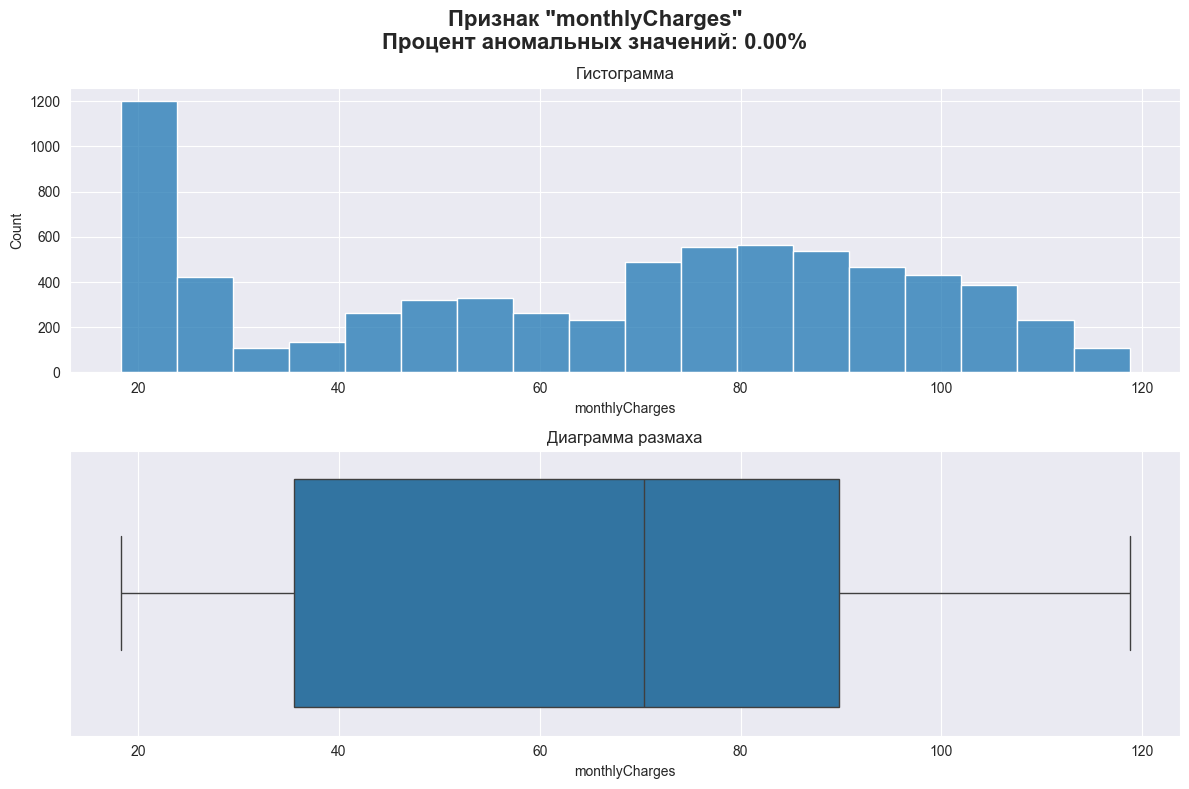

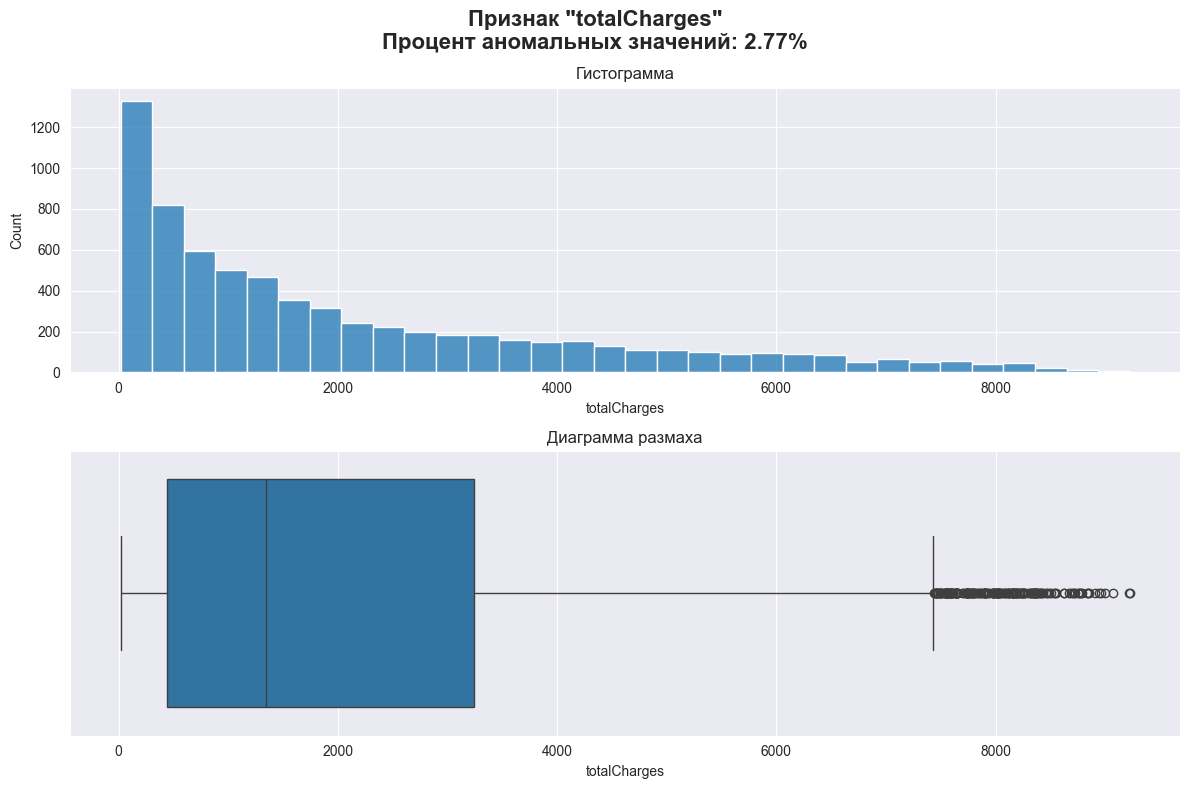

Корреляция Пирсона для числовых признаков


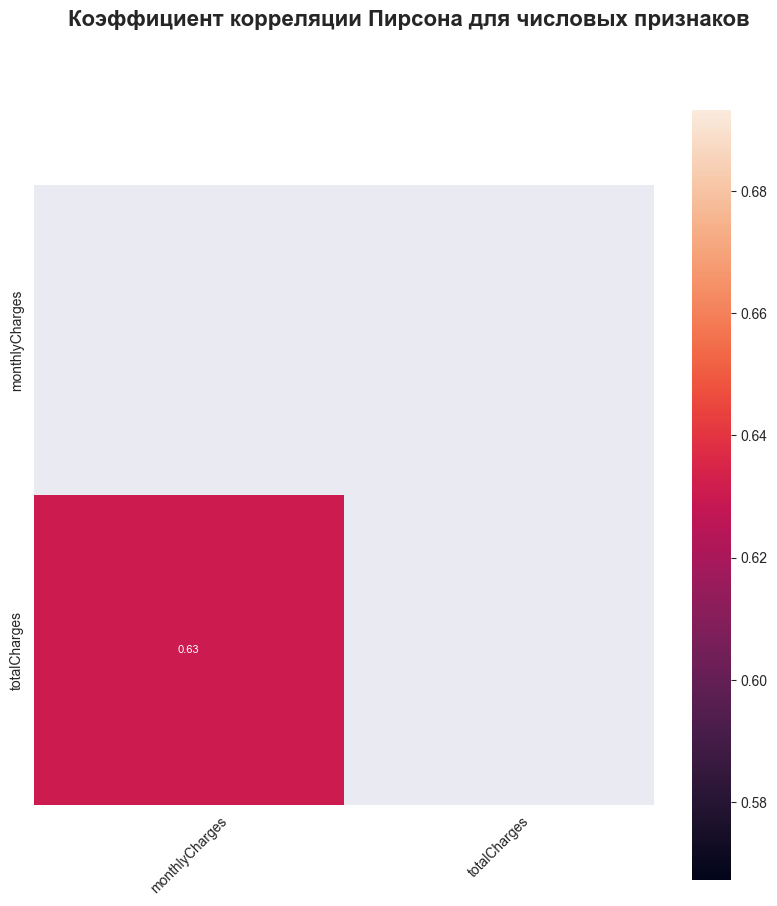


Категориальные признаки
--------------------


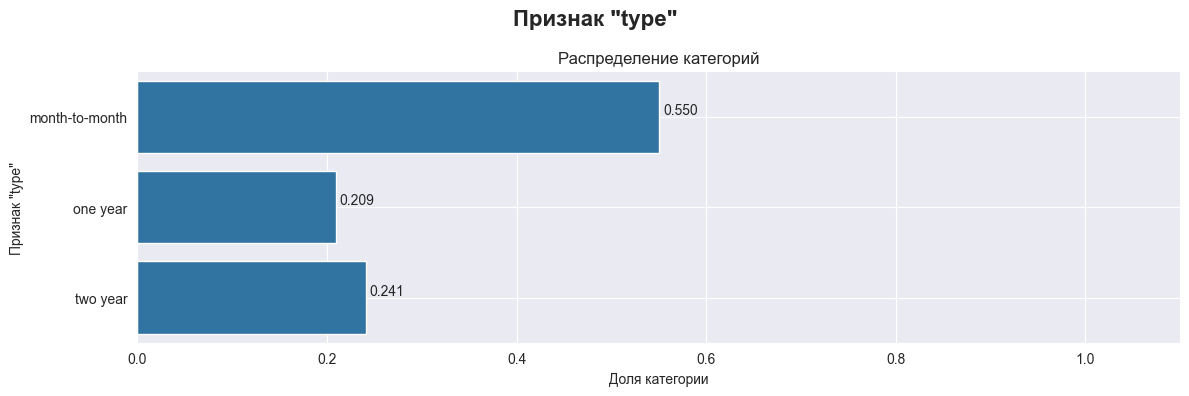

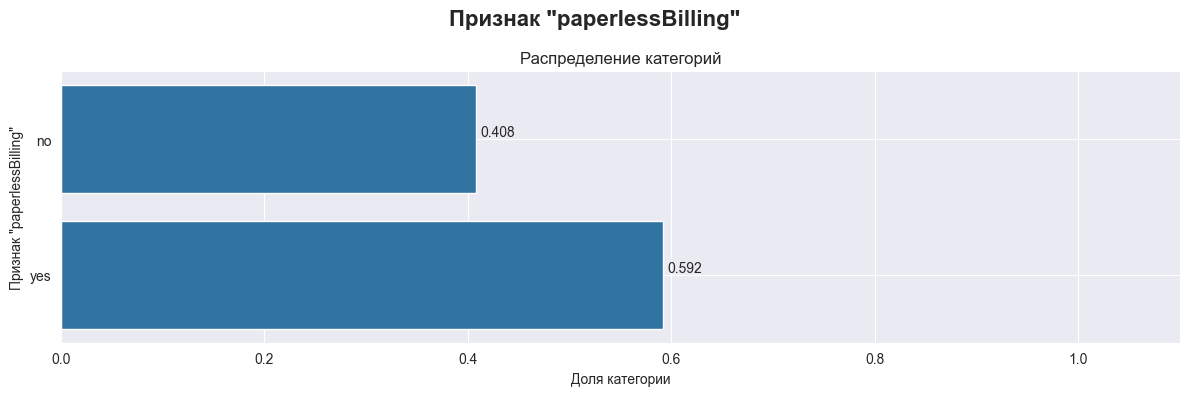

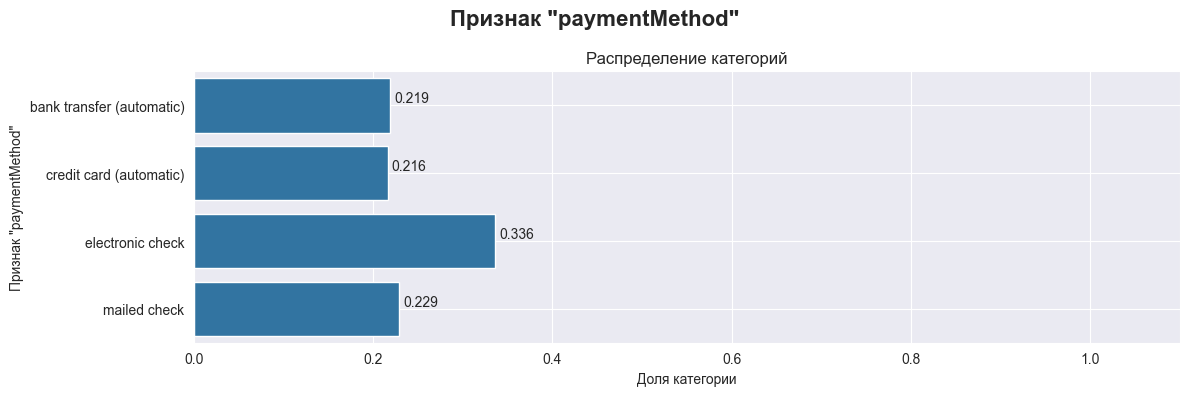

Корреляция Крамера для категориальных признаков


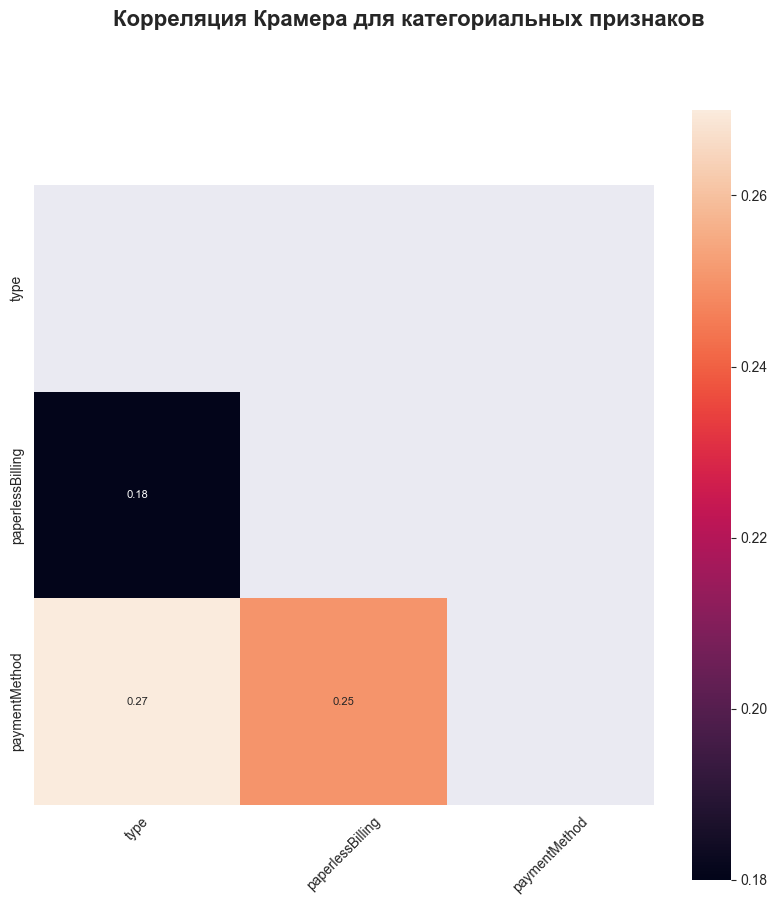


Временные признаки
--------------------


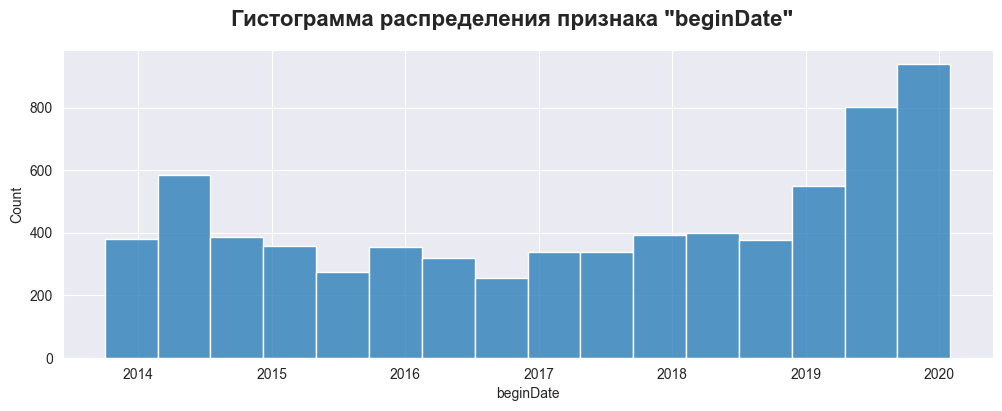

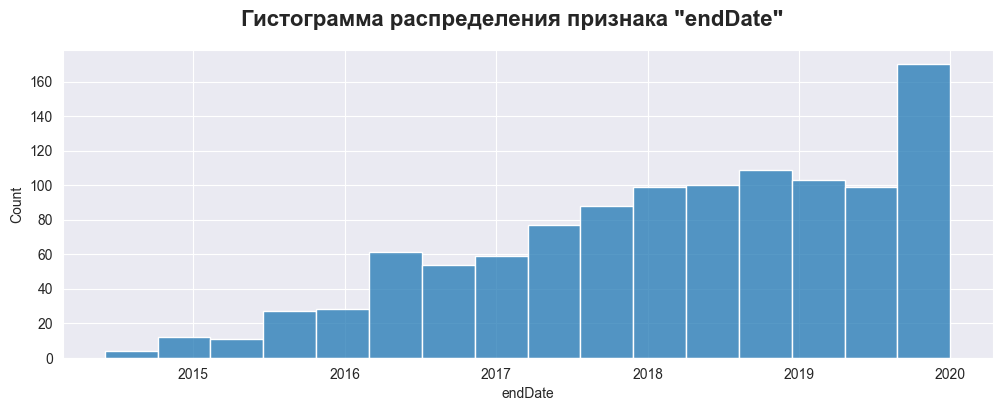



Коэффициент взаимной информации всех признаков


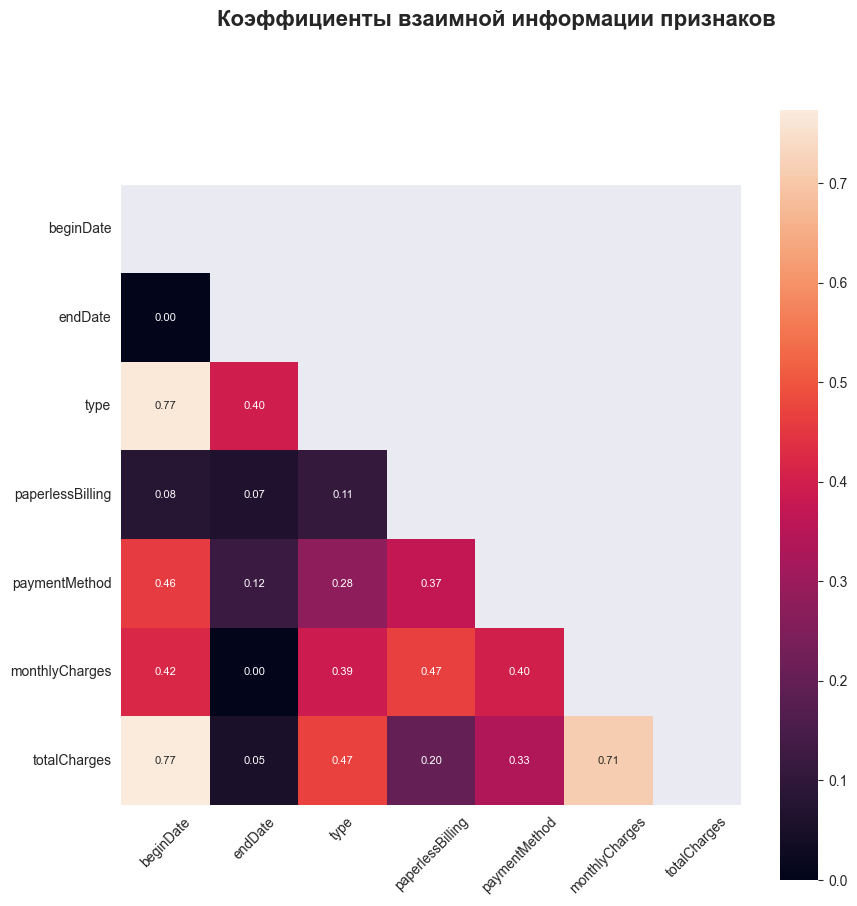

----------------------------------------------------------------------
Информация о таблице personal
--------------------
Первые 5 строк датасета


,customerId,gender,seniorCitizen,partner,dependents
0,7590-VHVEG,female,no,yes,no
1,5575-GNVDE,male,no,no,no
2,3668-QPYBK,male,no,no,no
3,7795-CFOCW,male,no,no,no
4,9237-HQITU,female,no,no,no


Информация о пропусках в датасете


,customerId,gender,seniorCitizen,partner,dependents
Кол-во пропусков,0.0,0.0,0.0,0.0,0.0
Процент пропусков,0.0,0.0,0.0,0.0,0.0


Количество дубликатов: 0

Количественные признаки
--------------------
В таблице нет количественных признаков


Категориальные признаки
--------------------


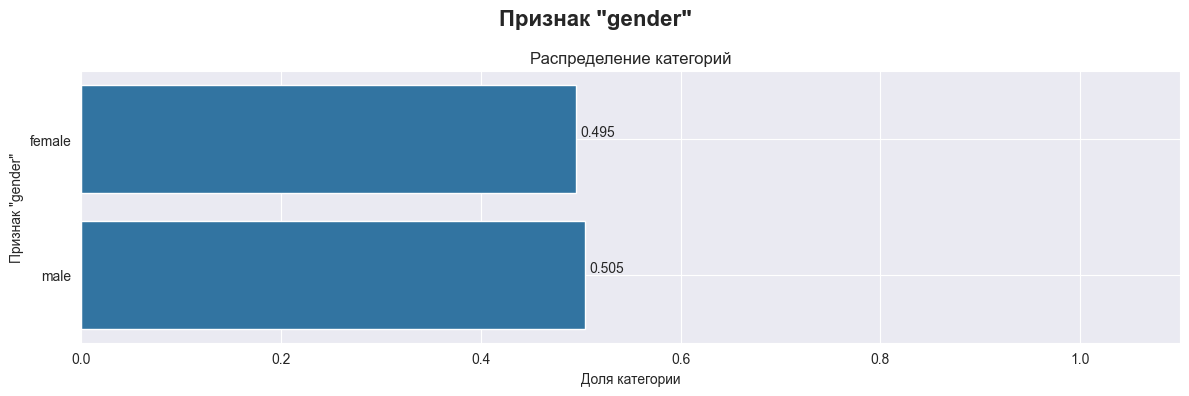

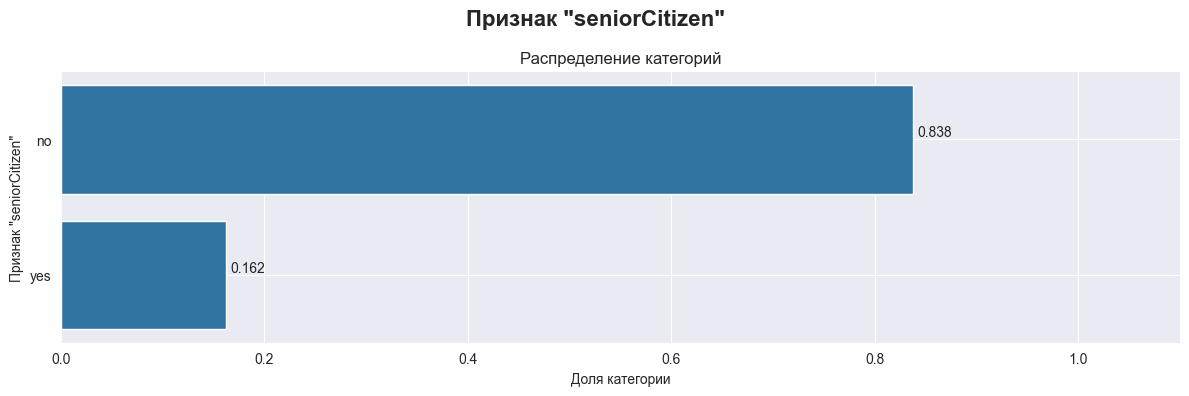

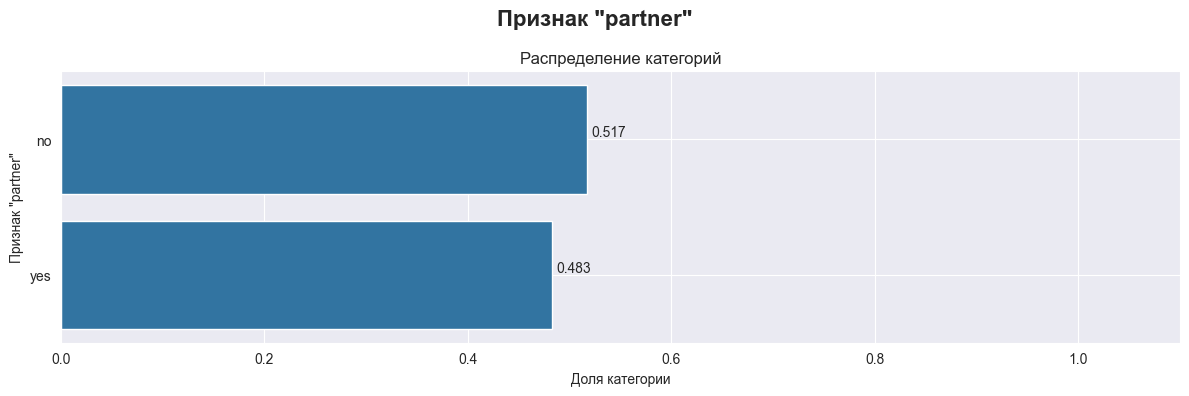

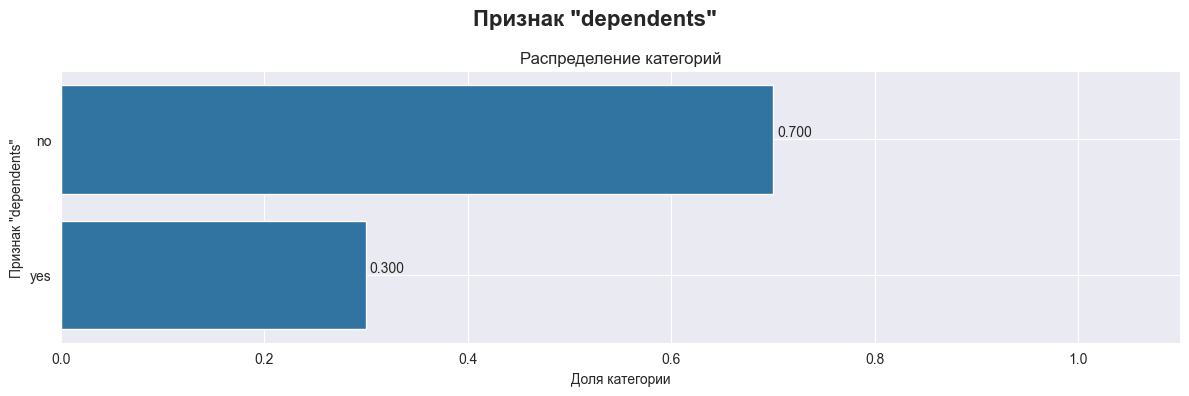

Корреляция Крамера для категориальных признаков


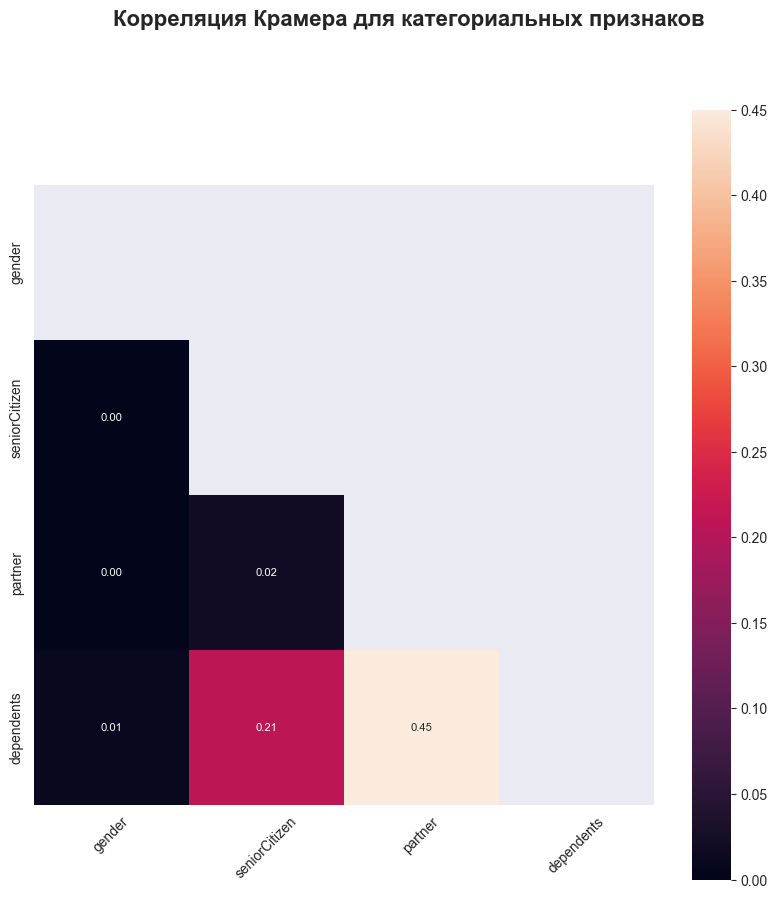


Временные признаки
--------------------
В таблице нет временных признаков

Коэффициент взаимной информации всех признаков


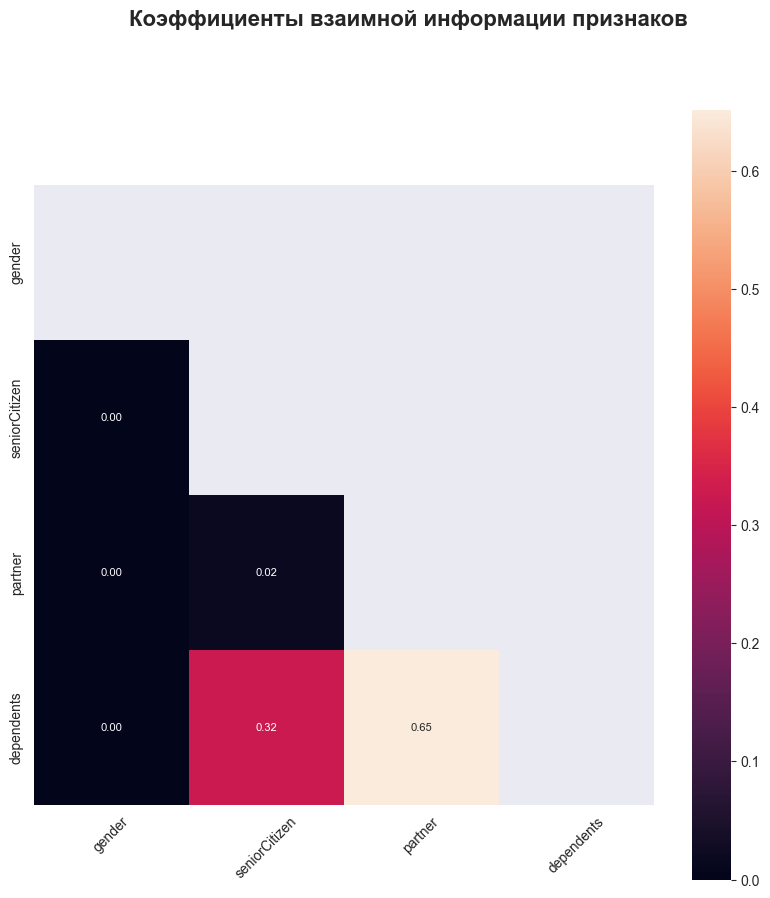

----------------------------------------------------------------------
Информация о таблице internet
--------------------
Первые 5 строк датасета


,customerId,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies
0,7590-VHVEG,dsl,no,yes,no,no,no,no
1,5575-GNVDE,dsl,yes,no,yes,no,no,no
2,3668-QPYBK,dsl,yes,yes,no,no,no,no
3,7795-CFOCW,dsl,yes,no,yes,yes,no,no
4,9237-HQITU,fiber optic,no,no,no,no,no,no


Информация о пропусках в датасете


,customerId,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies
Кол-во пропусков,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Процент пропусков,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Количество дубликатов: 0

Количественные признаки
--------------------
В таблице нет количественных признаков


Категориальные признаки
--------------------


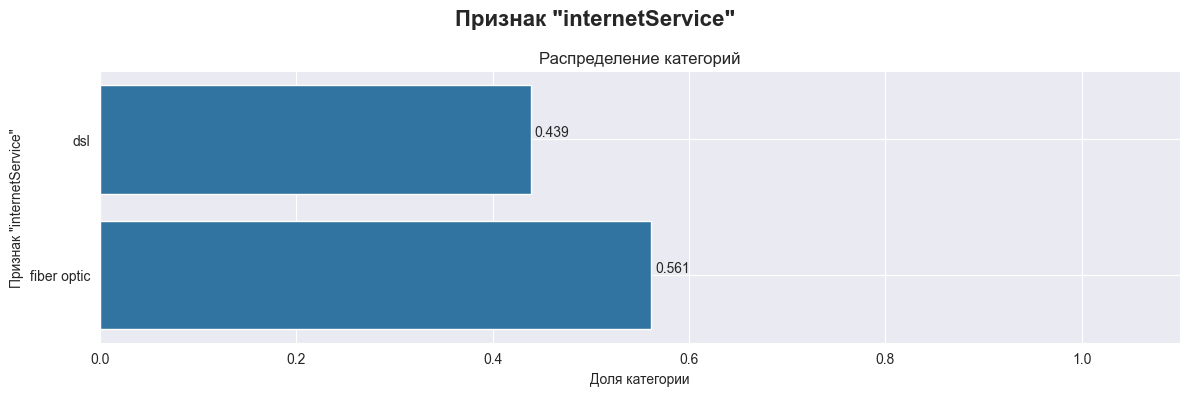

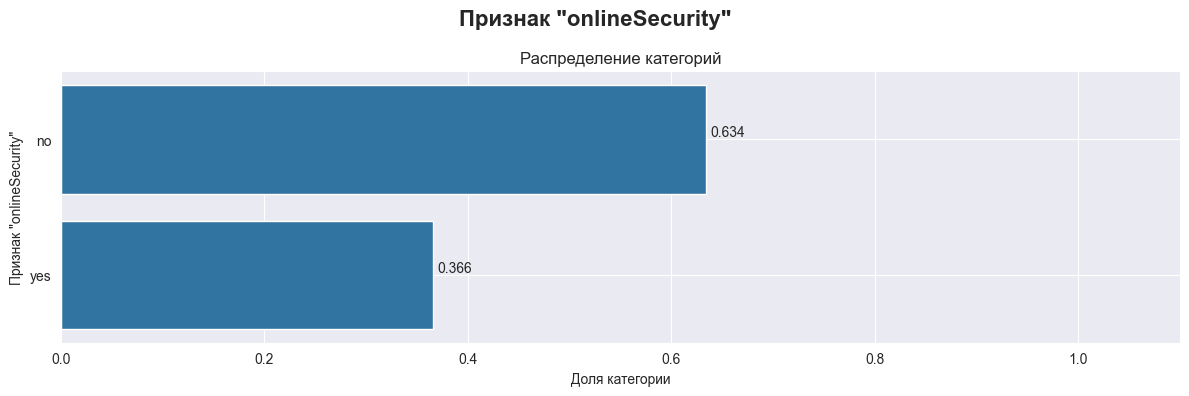

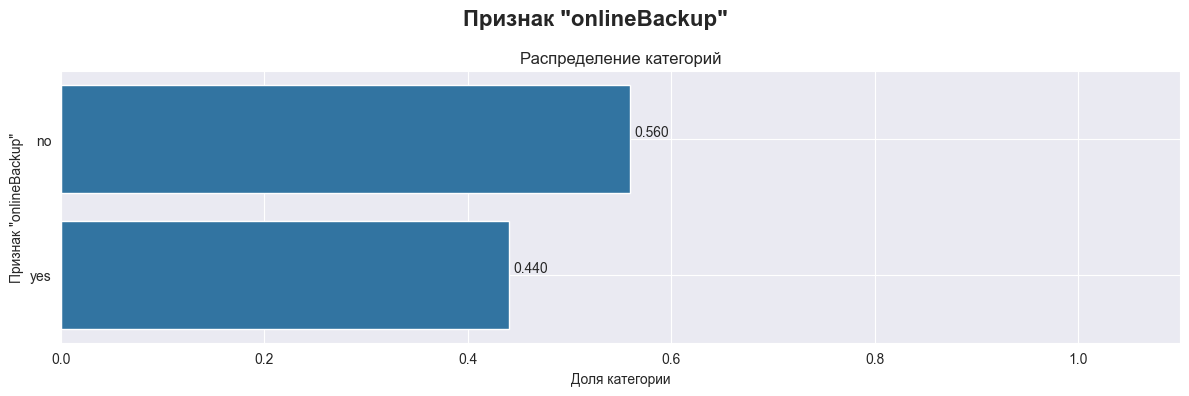

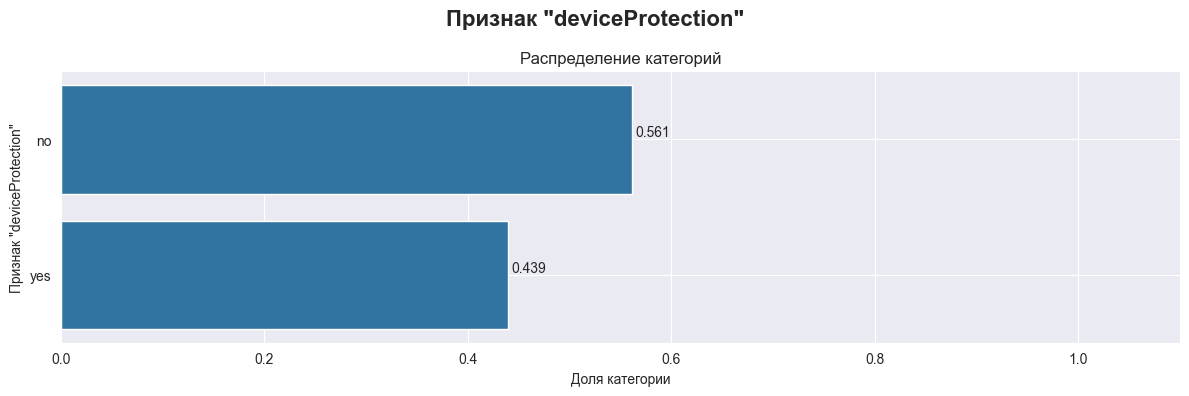

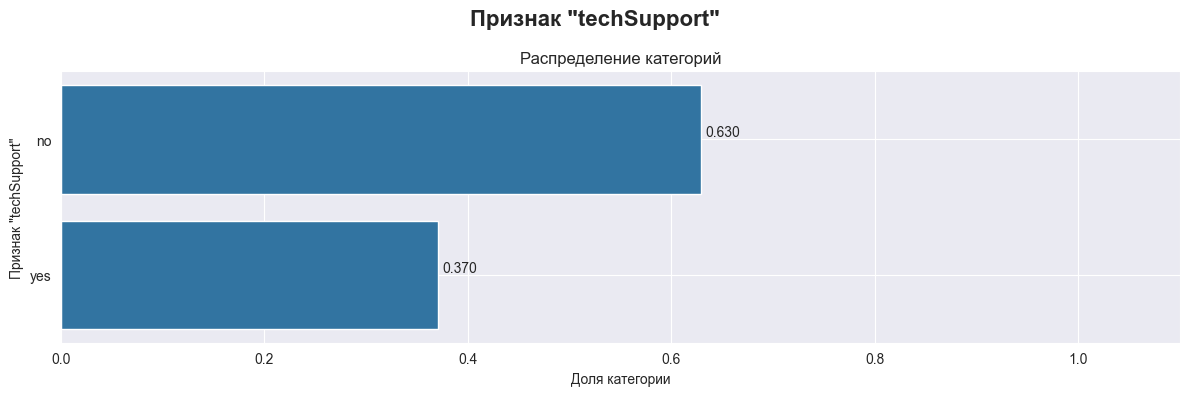

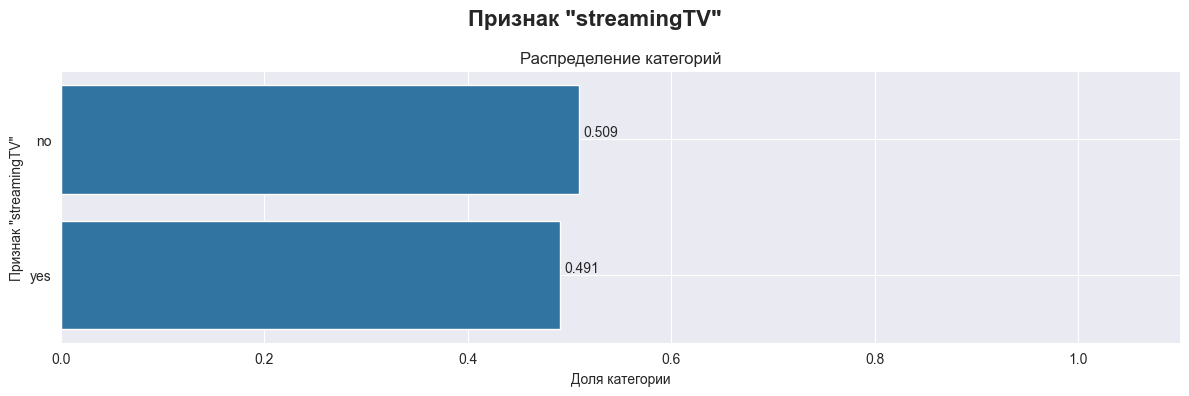

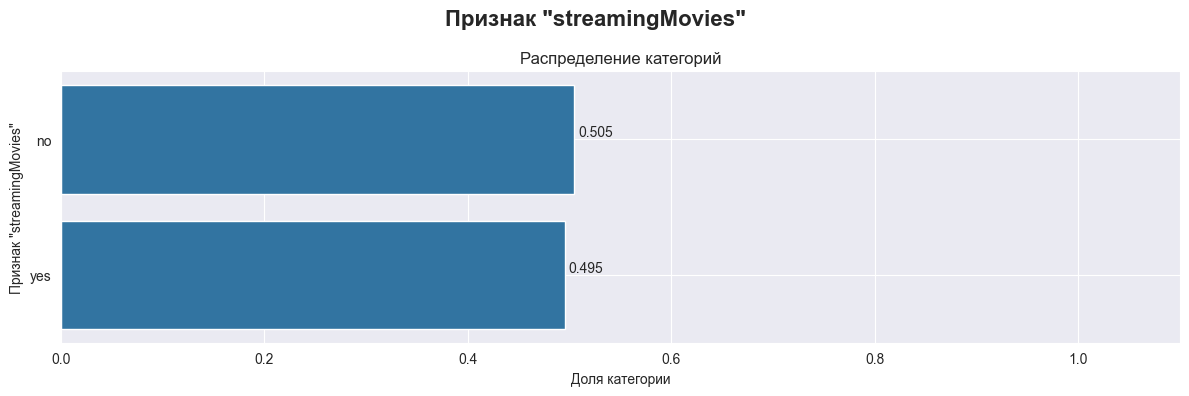

Корреляция Крамера для категориальных признаков


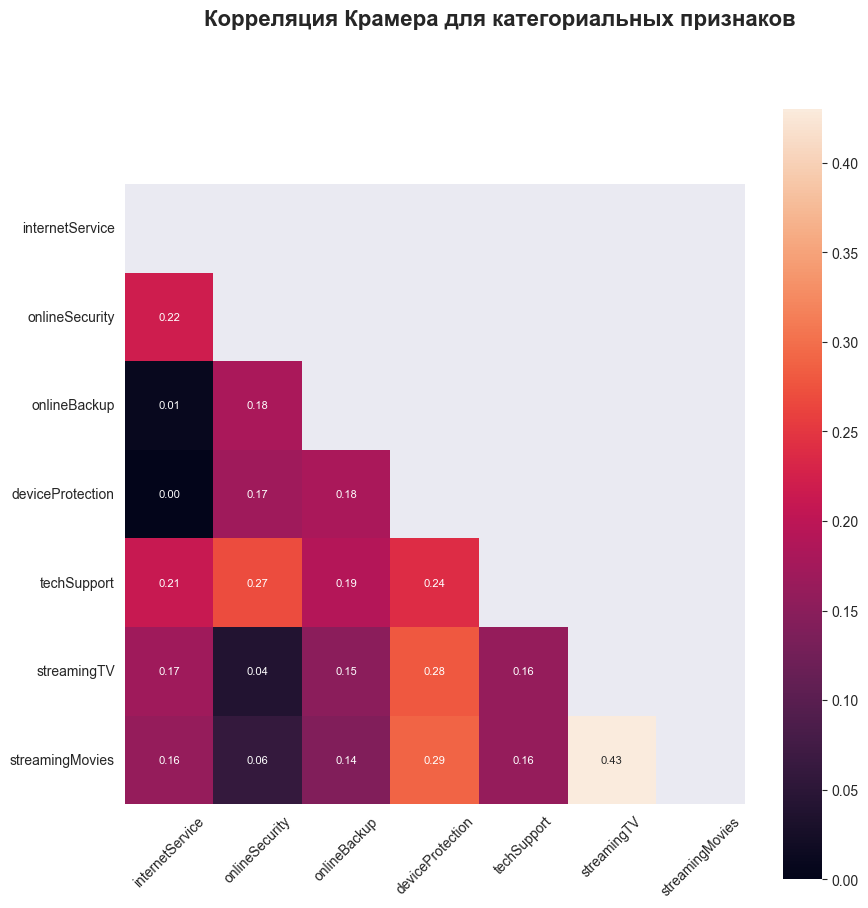


Временные признаки
--------------------
В таблице нет временных признаков

Коэффициент взаимной информации всех признаков


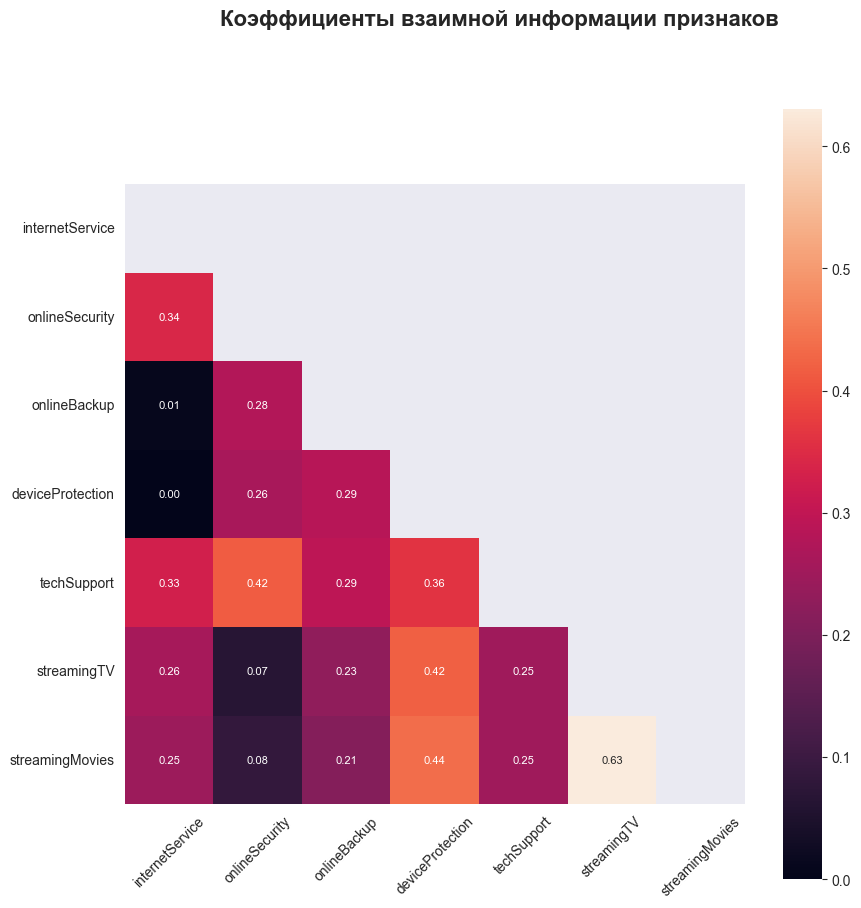

----------------------------------------------------------------------
Информация о таблице phone
--------------------
Первые 5 строк датасета


,customerId,multipleLines
0,5575-GNVDE,no
1,3668-QPYBK,no
2,9237-HQITU,no
3,9305-CDSKC,yes
4,1452-KIOVK,yes


Информация о пропусках в датасете


,customerId,multipleLines
Кол-во пропусков,0.0,0.0
Процент пропусков,0.0,0.0


Количество дубликатов: 0

Количественные признаки
--------------------
В таблице нет количественных признаков


Категориальные признаки
--------------------


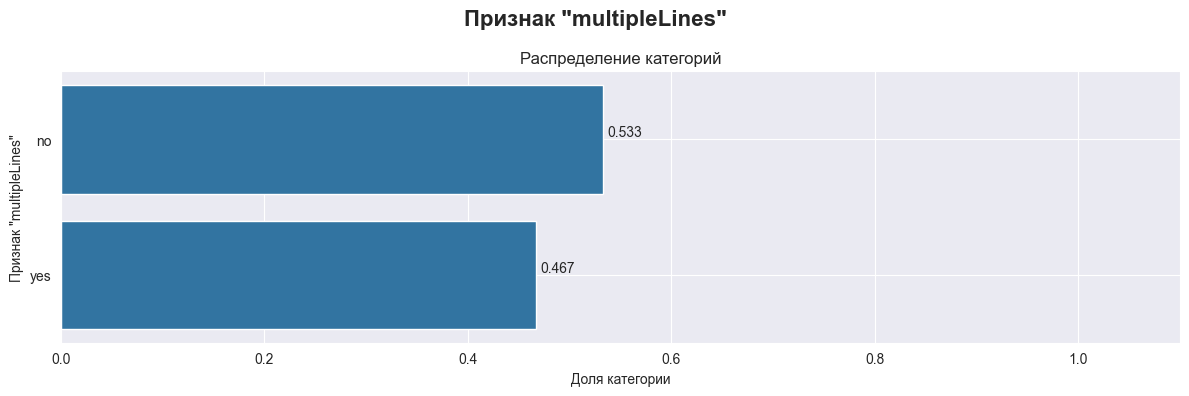

Корреляция Крамера для категориальных признаков
Невозможно построить Матрицу корреляции Крамера для категориальных признаков, так как в таблице только 1 категориальный признак

Временные признаки
--------------------
В таблице нет временных признаков

Коэффициент взаимной информации всех признаков
Невозможно построить Матрицу коэффициентов взаимной информации признаков, так как в таблице только 1 признак
----------------------------------------------------------------------


In [37]:
for df, df_name in zip([contract, personal, internet, phone], TABLE_NAME):
    create_eda_dataset(df, df_name)

**Вывод:**  
1. Таблица `Contract`  
Дубликатов в таблице нет. Столбце `endDate` содержит 5942 (`84.37%`) пропусков. Столбец `totalCharges` содержит 11 (`0.16%`) пропусков.  
Содержит следующие столбцы 
* `monthlyCharges` - расходы за месяц  
Распределение значений - бимодальное. Выбросов нет  

* `totalCharges` - общие расходы абонента  
Распределение значение - ассиметричное. Большинсво значение сконцентрированы ближе к 0. Есть `2.77%` выбросов. Однако, вероятно, это свзано с тем, что абоненты, которые давно пользуются услугами, будут иметь большие общие расходны (по накопительной системе)  

* `type` - тип оплаты  
Категориальный признак, содержит 3 значения: `month-to-month`, `one year`, `two year`. Большинство абонентов(`55%`) пользуется помесячной оплатой. 
  
* `paperiessBilling` - электронный расчётный лист  
По столбчатой диаграмме видно, что `59.2%` абонентов получают электронные рассчетные листы  

* `paymentMethod` - тип платежа  
Большинство абонентов (`33.6`) предпочитают получать электронные чеки. Остальные категории распределены примерно в расных долях

* `beginDate` - дата начала действия договора.  
В выборке присутствуют договоры заключенные с 2014 по 2020 года. В 2019 и 2020 года количество заключаемых договоров увеличилось.  

* `endDate` - дата окончания действия договора  
По гистограмме видно, что со временем количество расторжений договоров увеличивалось. Данные признак будет основой для создания целевого признака: если значение в столбце заполненно - целевой признак будет равен 1, если нет, то - 0.

Высокий коэффициент взаимной информации наюлюдается между признаками:
* `beginDate` и `type` - `0.77`
* `totalCharges` и `monthlyCharges` - `0.71`

2. Таблица `personal`  
Дубликатов и пропусков в таблице нет.  
Содержит следующие столбцы  
* `gender` — пол
Смещение по полу среди клиентов не наблюдается. Мужчины и женщины пользуются услугами компании примерно в равных долях

* `seniorCitizen` — является ли абонент пенсионером
Большая часть абонетов (`83.8%`) не являются пенсионерами.

* `partner` — есть ли у абонента супруг или супруга
Абоненты с супругами и без супругов присутствуют среди абонентов примерно в равных долях. `51.7%` абонентов не имеют супругов, а `48.3%` абонентов имеют супругов.

* `dependents` — есть ли у абонента дети
Большинство абонентов `70%` не имеют детей

Таблица не содержит высоких коэффициентов взаимной информации признаков (больше `0.7`)

3. Таблица `internet`  
Дубликатов и пропусков в таблице нет.  
Содержит следующие столбцы:  
* `internetService` — тип подключения
Большая часть абонентов (`56.1%`) пользуются интернетом с типом подключения `fiber optic`

* `onlineSecurity` — блокировка опасных сайтов
Услугой блокировки опасных сайнов пользуюется `36.6%` абонентов

* `onlineBackup` — облачное хранилище файлов для резервного копирования данных
Услугой облачного хранилища файлов пользуется `44%` абонентов.

* `deviceProtection` — антивирус
Услугой антивируса пользуется `43.9%` абонетов.

* `techSupport` — выделенная линия технической поддержки
Услугой выделенной линии тех. поддержки пользуется `37%` абонентов.

* `streamingTV` — стриминговое телевидение
Услугой стримингового телевидения пользуется `49.1%` абонентов

* `streamingMovies` — каталог фильмов
Катологов фильмов пользуется `49.5%` абонентов

Таблица не содержит высоких коэффициентов взаимной информации признаков 

4. Таблица `phone`
Дубликатов и пропусков в таблице нет.  
Содержит следующие столбцы: 
* `multipleLines` — подключение телефона к нескольким линиям одновременно
Услугой подключения к нескольким линиям одновременно пользуется `46.7%` абонентов.

## Объединение таблиц

Объединим все таблицы в одну по столбцу `customerId`

In [38]:
df_merge = (
    contract
    .merge(personal, how='left', on='customerId')
    .merge(internet, how='left', on='customerId')
    .merge(phone, how='left', on='customerId')
)

In [39]:
df_merge.head()

,customerId,beginDate,endDate,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies,multipleLines
0,7590-VHVEG,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,female,no,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-GNVDE,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,male,no,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,male,no,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,male,no,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-HQITU,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,female,no,no,no,fiber optic,no,no,no,no,no,no,no


In [40]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerId        7043 non-null   object        
 1   beginDate         7043 non-null   datetime64[ns]
 2   endDate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   category      
 4   paperlessBilling  7043 non-null   category      
 5   paymentMethod     7043 non-null   category      
 6   monthlyCharges    7043 non-null   float64       
 7   totalCharges      7032 non-null   float64       
 8   gender            7043 non-null   category      
 9   seniorCitizen     7043 non-null   category      
 10  partner           7043 non-null   category      
 11  dependents        7043 non-null   category      
 12  internetService   5517 non-null   category      
 13  onlineSecurity    5517 non-null   category      
 14  onlineBackup      5517 n

### Работа с пропусками

Можно заметить, что после объединения у нас появились пропуски. Это ожидаемо, так как не каждый клиент подключает и интернет и телефонию. Пропуски в категориальных столбцах, связанных с услугой `Интернет` заполним значением `internet not connected`, а пропуски в категориальных столбцах, связанных с услугой `Телефон` заполним значением `phone not connected`.

In [41]:
interner_columns = [
    'internetService', 'onlineSecurity', 'onlineBackup',
    'deviceProtection', 'techSupport','streamingTV', 'streamingMovies'
]
new_internet_value = 'internet not connected'
phone_columns = ['multipleLines']
new_phone_value = 'phone not connected'
for column in interner_columns:
    if new_internet_value not in df_merge[column].cat.categories:
        df_merge[column] = df_merge[column].cat.add_categories(new_internet_value)
    df_merge.fillna({column: new_internet_value}, inplace=True)
    
for column in phone_columns:
    if new_phone_value not in df_merge[column].cat.categories:
        df_merge[column] = df_merge[column].cat.add_categories(new_phone_value)
    df_merge.fillna({column: new_phone_value}, inplace=True)

Из столбца `endDate` сформируем целевую переменную:  
* Если для клиента в столбце `None`, значит клиент не ушел и заполняем целевую переменную значение `0`
* Если для клиента в столбце заполнено значение, значит он отказался от услуг оператора и заполняем целевую переменную значением `1`

In [42]:
df_merge['isOutflow'] = df_merge['endDate'].notnull().astype('int').astype('category')

Теперь можно заполнить пропуски в столбце `endDate`. Так как данные актуальны на `01-02-2020`, то заполним пропуски в столбце этой датой

In [43]:
df_merge.fillna({'endDate': pd.Timestamp('2020-02-01')}, inplace=True)

Изучим пропуски в столбце `totalCharges`.

In [44]:
df_merge.loc[df_merge['totalCharges'].isna(), ['monthlyCharges', 'totalCharges', 'beginDate', 'endDate']]

,monthlyCharges,totalCharges,beginDate,endDate
488,52.55,NaN,2020-02-01,2020-02-01
753,20.25,NaN,2020-02-01,2020-02-01
936,80.85,NaN,2020-02-01,2020-02-01
1082,25.75,NaN,2020-02-01,2020-02-01
1340,56.05,NaN,2020-02-01,2020-02-01
3331,19.85,NaN,2020-02-01,2020-02-01
3826,25.35,NaN,2020-02-01,2020-02-01
4380,20.00,NaN,2020-02-01,2020-02-01
5218,19.70,NaN,2020-02-01,2020-02-01
6670,73.35,NaN,2020-02-01,2020-02-01


Можно заметить, что все пропуски сделаны в договорах, которые заключены на актуальную дату выгрузки. Поэтому общие расходы абонента будет равны его расходам за месяц. Заполним пропуски значением из столбца `monthlyCharges`

In [45]:
df_merge.loc[df_merge['totalCharges'].isna(), 'totalCharges'] = df_merge.loc[df_merge['totalCharges'].isna(), 'monthlyCharges']

Пропусков в датасете больше не осталось

### Создание признаков

Предположение: чем дольше клиент пользуется нашими услугами, тем более лояльным он является.  
Посчитаем длительность оказания услуг в месяцах

In [46]:
df_merge['duration'] = (
    df_merge['endDate'].dt.to_period('M').astype('int64') - 
    df_merge['beginDate'].dt.to_period('M').astype('int64')
)

Предположение: чем больше у пользователя подключено услуг, тем больше его жизнь завязана на наш сервис.  
Поэтому посчитаем количество подключенных дополнительных услуг

In [47]:
df_merge['countService'] = (
    df_merge[[
        'onlineSecurity', 'onlineBackup', 'deviceProtection', 'techSupport',
        'streamingTV', 'streamingMovies', 'multipleLines']] == 'yes'
).sum(axis=1)

Предполложение: если расходы абонента начали снижаться, то у него уменьшается необходимость в наших услугах и он может скоро уйти.  
Поэтому рассчитаем меньше ли расходы абонента за месяц по сравнению с его среднемесячными расходами

In [48]:
df_merge['monthlyChargesLess'] = (
    df_merge['monthlyCharges'] < df_merge['totalCharges'] / df_merge['duration']
).astype('int').astype('category')

Предположение: когда оплаченный период подъодит к концу, клиент может принять решение прекратить сотрудничество.  
Рассчитаем, какая доля конракта осталась до наступления последнего месяца. Например, длятельность контракта 20 месяце. Периодичность оплаты 1 раз в год. Тогда до наступления последнего месяца остается (12 - 1 - 20%12) / 12 = 3 / 12 = 0.25. Для ежемесячной оплаты значение всегда будет равно 0. Это клиенты, которых легче всего потерять

In [49]:
def get_remains(row):
    period = None
    if row['type'] == 'month-to-month':
        period = 1
    elif row['type'] == 'one year':
        period = 12
    else:
        period = 24
    return (period - 1 - (row['duration'] % period)) / float(period)

In [50]:
df_merge['remainsContract'] = df_merge.apply(get_remains, axis=1)

**Вывод:**  
После объединения таблиц в одну образовались дополнительные пропуски ведь не все клиенты пользовались и интернетом, и телефоном. Пропуски в категориальных столбцах, связанных с услугой `Интернет` заполним значением `internet not connected`, а пропуски в категориальных столбцах, связанных с услугой `Телефон` заполним значением `phone not connected`.  
Из столбца `endDate` был сформирован целевой признак:  
* Если для клиента в столбце `None`, значит клиент не ушел и заполняем целевую переменную значение `0`
* Если для клиента в столбце заполнено значение, значит он отказался от услуг оператора и заполняем целевую переменную значением `1`
  
После формирования целевой переменной пропускив  столбце `endDate` были заполнены датой актуальности данных - `2020-02-01`.  
Пропуски в столбце `totalCharges` были заполнены значениями из столбца `monthlyCharges`.  

Также были созданы новые признаки:
* `duration` - длительность пользования ислугами в месяцах  
* `countService` - количество полключенных услуг  
* `monthlyChargesLess` - бинарный признак, являются ли затраты абонента за последний месяц меньше его среднемесячных затрат
* `remainsContract` - какая доля оплаченного договора остается в запасе

### EDA объединенного датасета

Информация о таблице Объединенный датасет
--------------------
Первые 5 строк датасета


,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,...,deviceProtection,techSupport,streamingTV,streamingMovies,multipleLines,isOutflow,duration,countService,monthlyChargesLess,remainsContract
0,month-to-month,yes,electronic check,29.85,31.04,female,no,yes,no,dsl,...,no,no,no,no,phone not connected,0,1,1,1,0.000000
1,one year,no,mailed check,56.95,2071.84,male,no,no,no,dsl,...,yes,no,no,no,no,0,34,2,1,0.083333
2,month-to-month,yes,mailed check,53.85,226.17,male,no,no,no,dsl,...,no,no,no,no,no,0,4,2,1,0.000000
3,one year,no,bank transfer (automatic),42.30,1960.60,male,no,no,no,dsl,...,yes,yes,no,no,phone not connected,0,45,3,1,0.166667
4,month-to-month,yes,electronic check,70.70,353.50,female,no,no,no,fiber optic,...,no,no,no,no,no,0,5,0,0,0.000000


Информация о пропусках в датасете


,type,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,gender,seniorCitizen,partner,dependents,internetService,...,deviceProtection,techSupport,streamingTV,streamingMovies,multipleLines,isOutflow,duration,countService,monthlyChargesLess,remainsContract
Кол-во пропусков,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Процент пропусков,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Количество дубликатов: 4

Распределение классов целевого признака


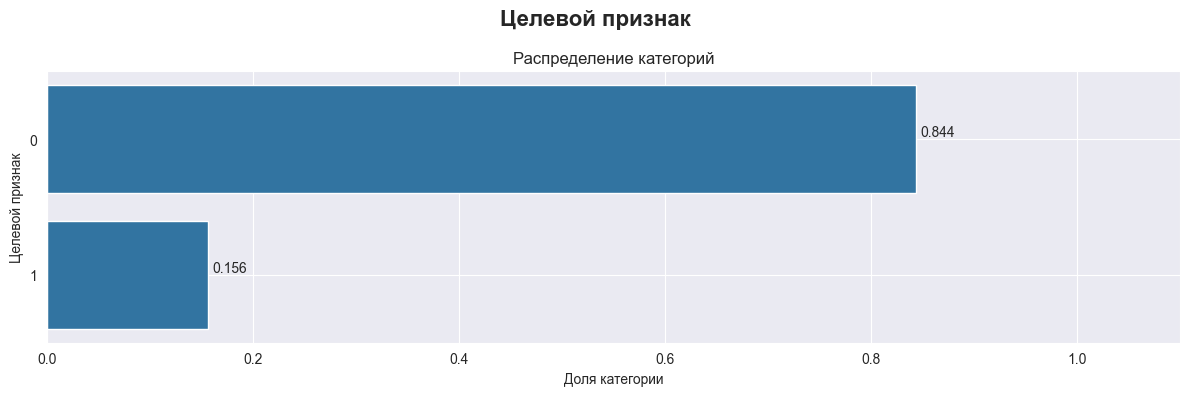


Количественные признаки
--------------------
Описательная статистика


,count,mean,std,min,25%,50%,75%,max
monthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.850000,118.750000
totalCharges,7043.0,2115.377573,2112.678861,19.05,436.75,1343.35,3236.690000,9221.380000
duration,7043.0,29.495385,22.446726,0.00,9.00,25.00,48.000000,76.000000
countService,7043.0,2.459747,2.045539,0.00,1.00,2.00,4.000000,7.000000
remainsContract,7043.0,0.213037,0.316968,0.00,0.00,0.00,0.416667,0.958333


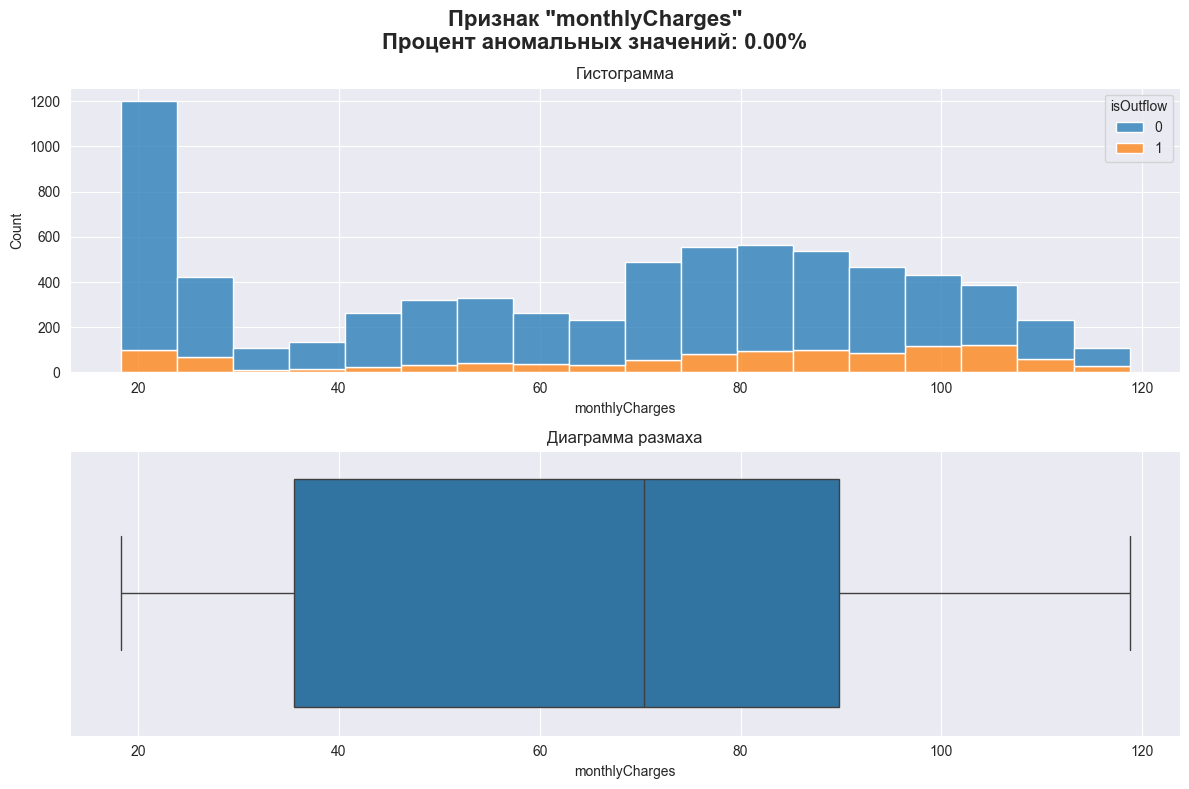

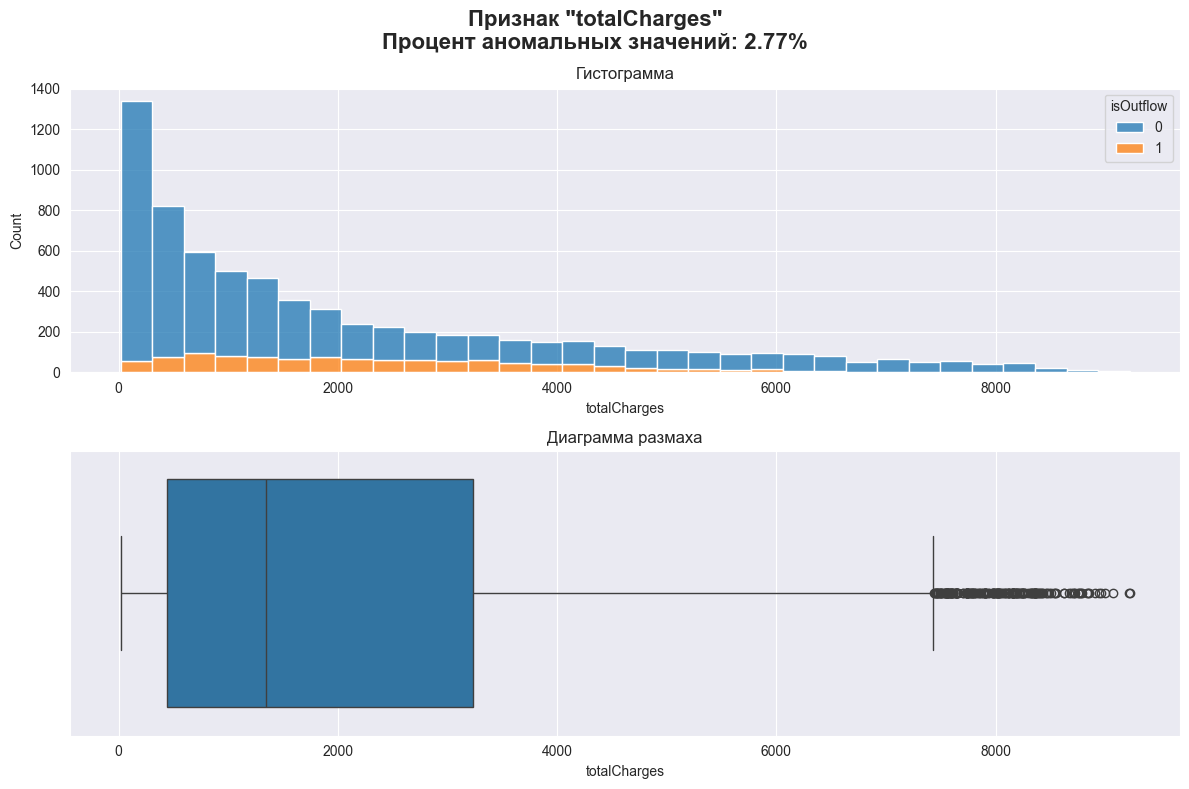

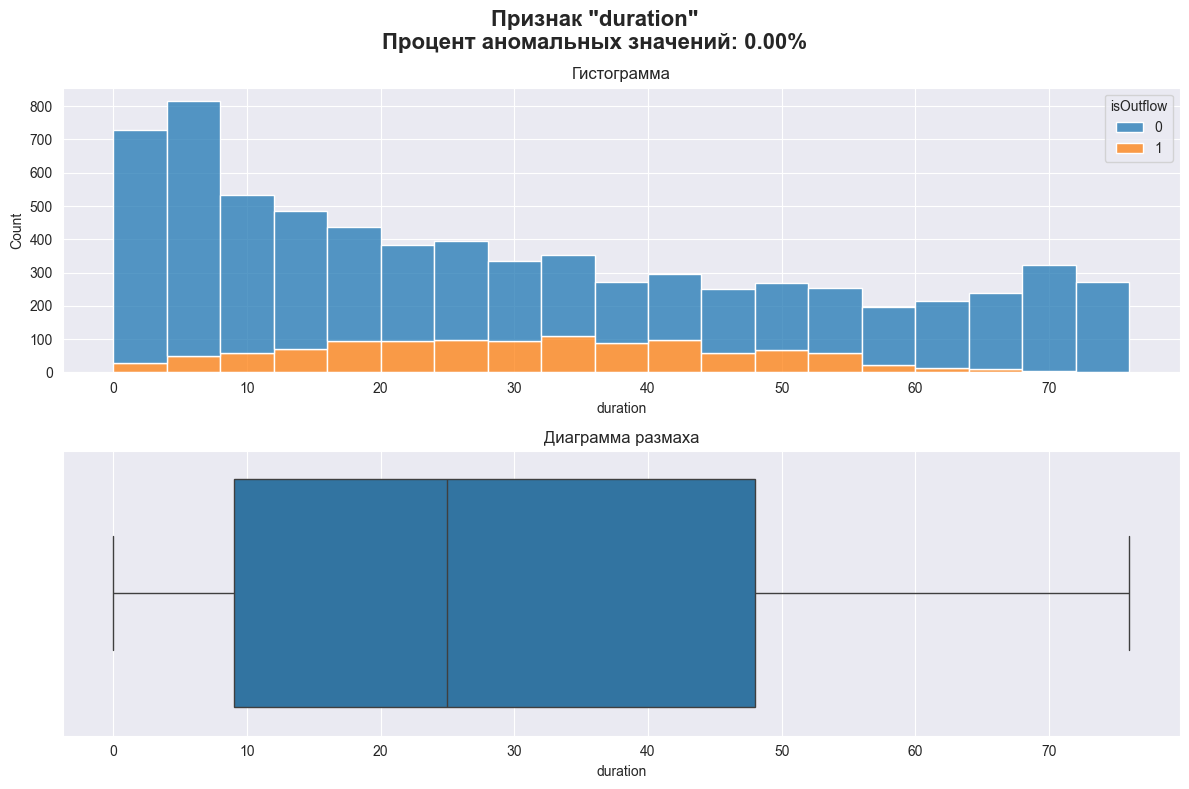

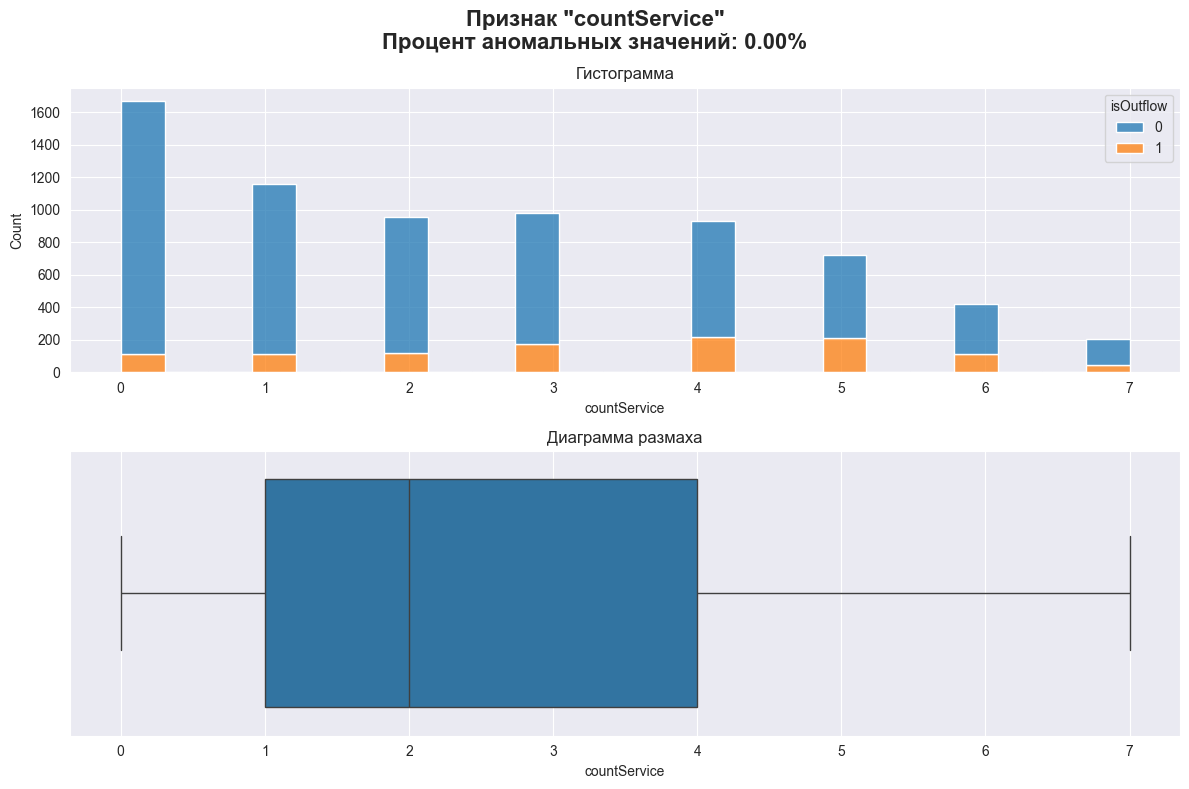

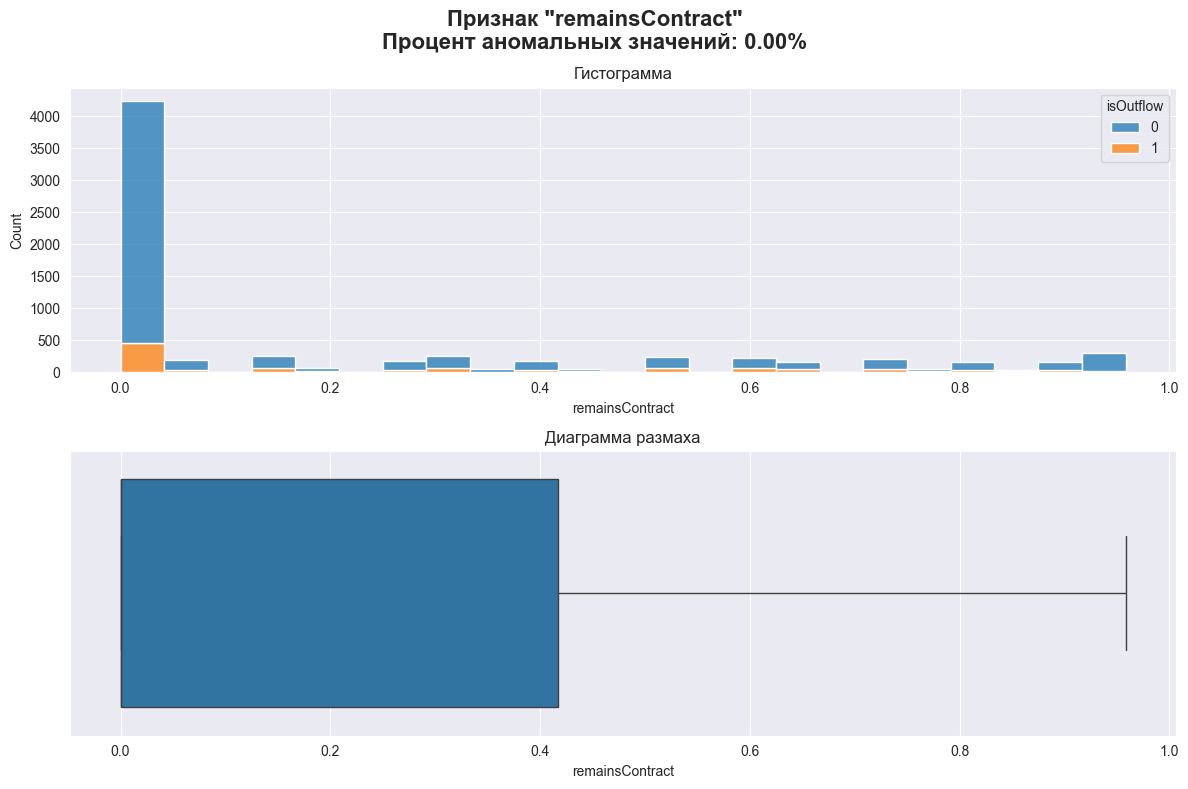

Корреляция Пирсона для числовых признаков


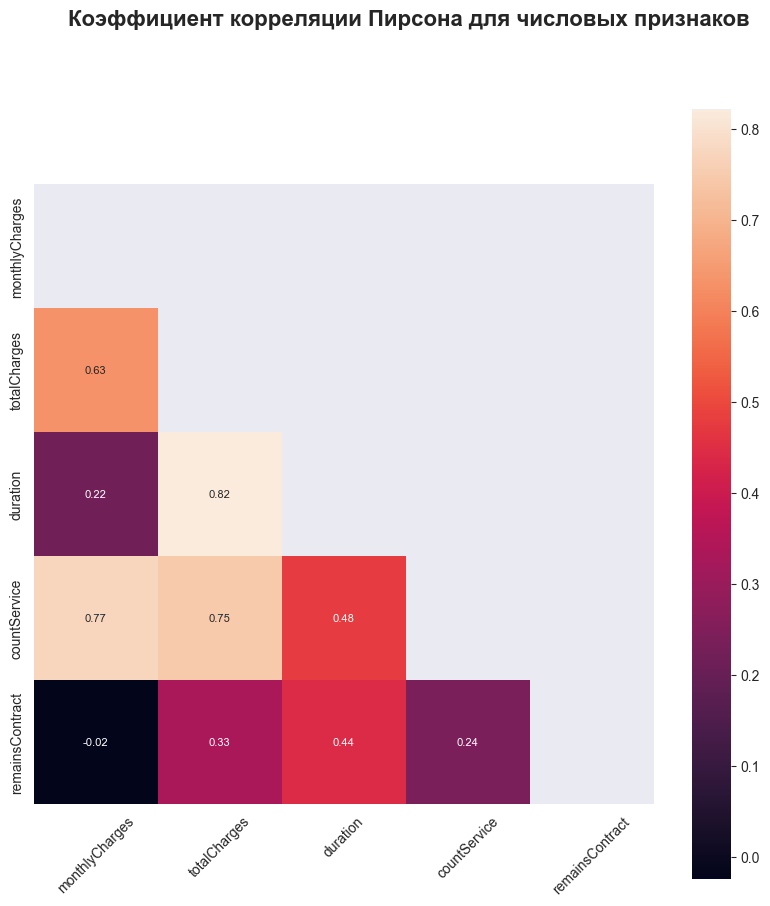


Категориальные признаки
--------------------


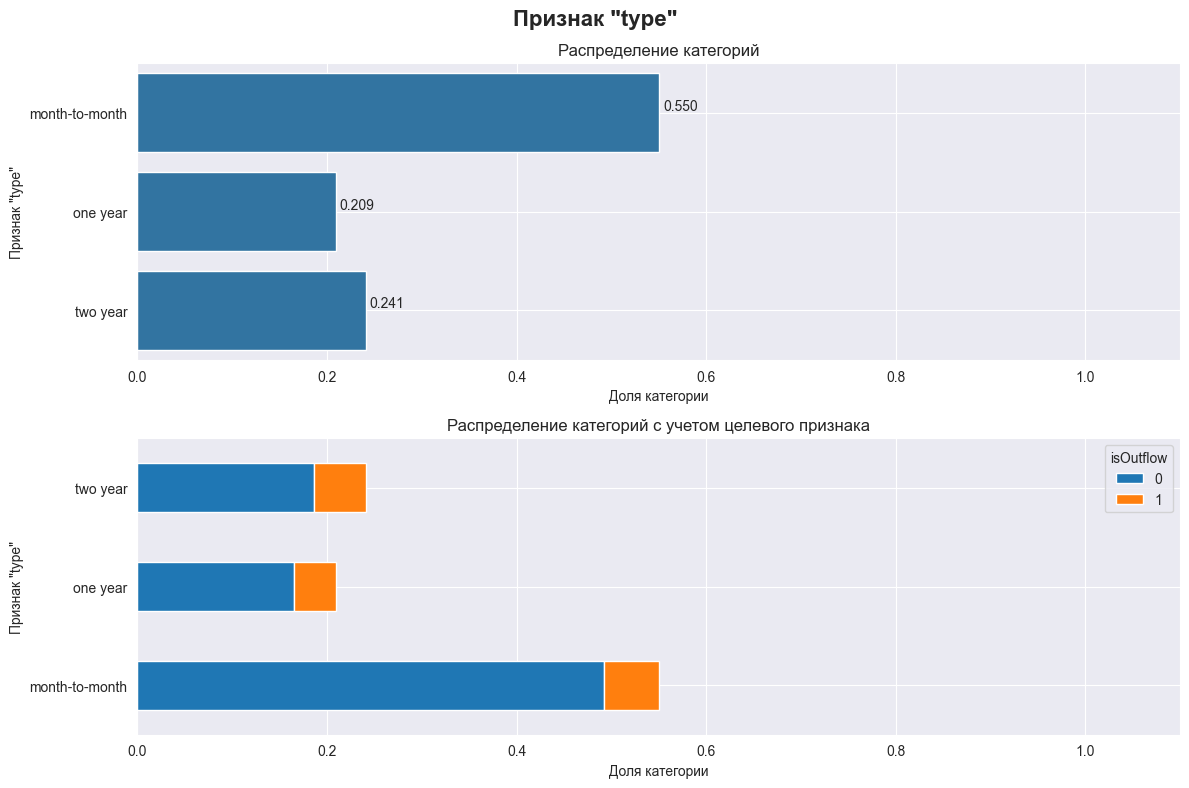

,type,isOutflow,count,persent
0,month-to-month,0,3468,89.50
3,month-to-month,1,407,10.50
2,one year,0,1160,78.75
5,one year,1,313,21.25
1,two year,0,1314,77.52
4,two year,1,381,22.48


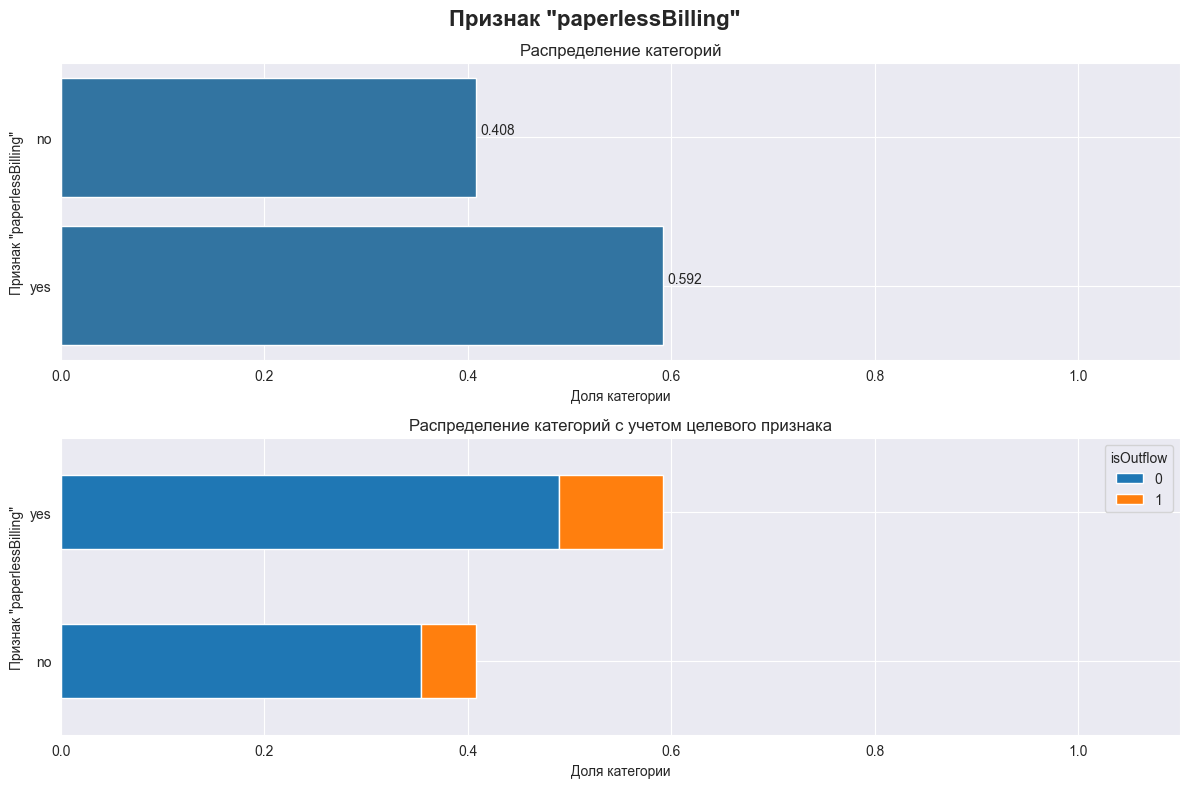

,paperlessBilling,isOutflow,count,persent
1,no,0,2492,86.77
3,no,1,380,13.23
0,yes,0,3450,82.71
2,yes,1,721,17.29


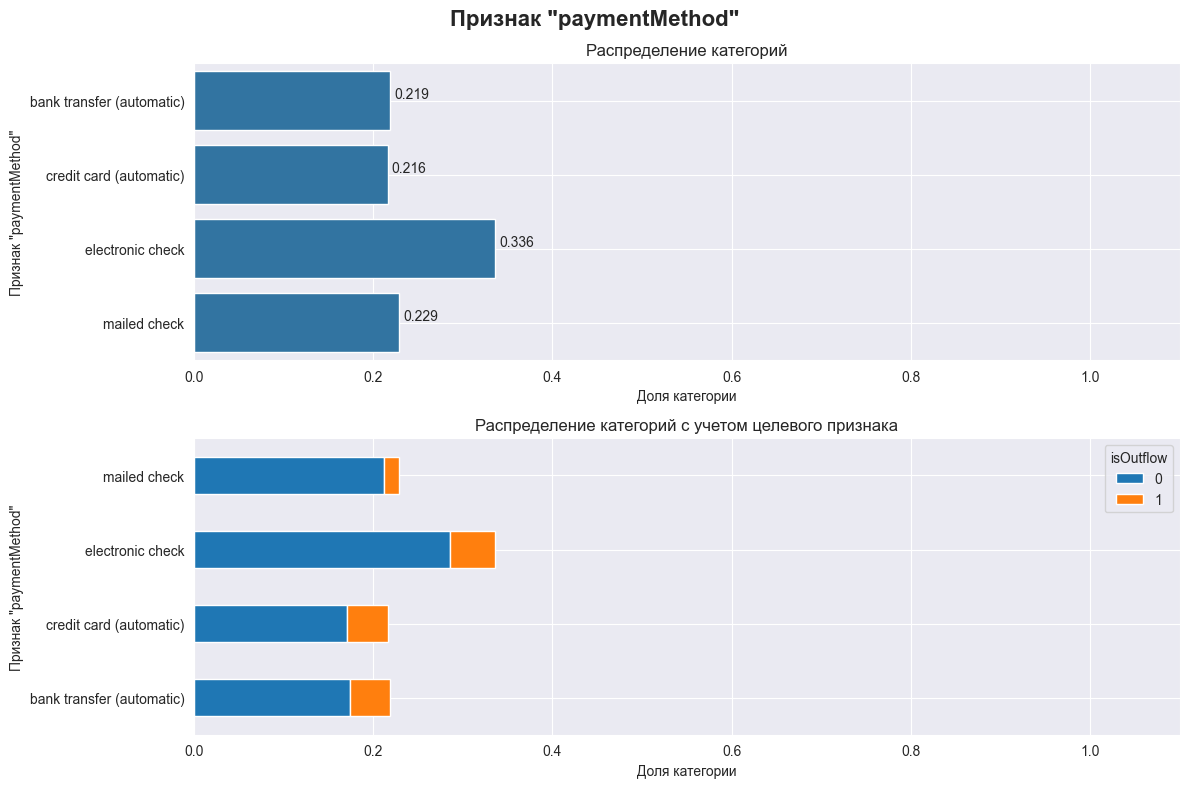

,paymentMethod,isOutflow,count,persent
2,bank transfer (automatic),0,1227,79.47
5,bank transfer (automatic),1,317,20.53
3,credit card (automatic),0,1205,79.17
6,credit card (automatic),1,317,20.83
0,electronic check,0,2015,85.20
4,electronic check,1,350,14.80
1,mailed check,0,1495,92.74
7,mailed check,1,117,7.26


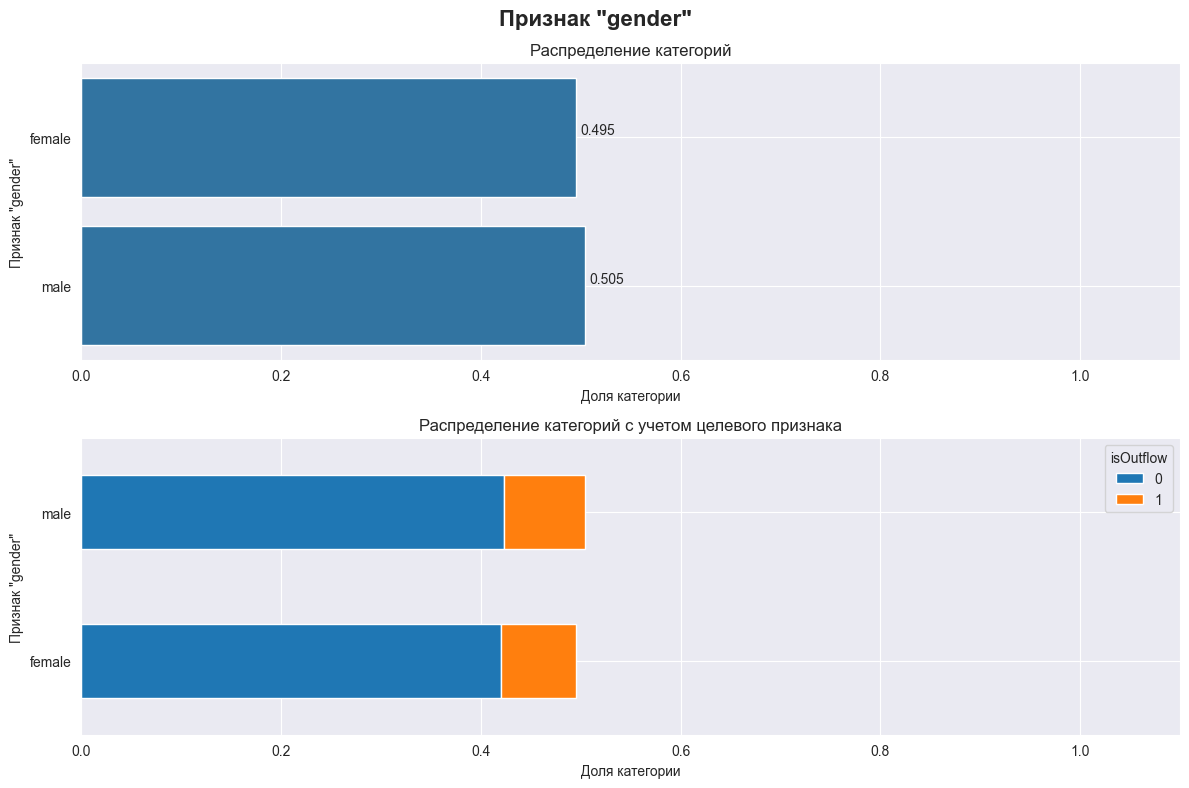

,gender,isOutflow,count,persent
1,female,0,2960,84.86
3,female,1,528,15.14
0,male,0,2982,83.88
2,male,1,573,16.12


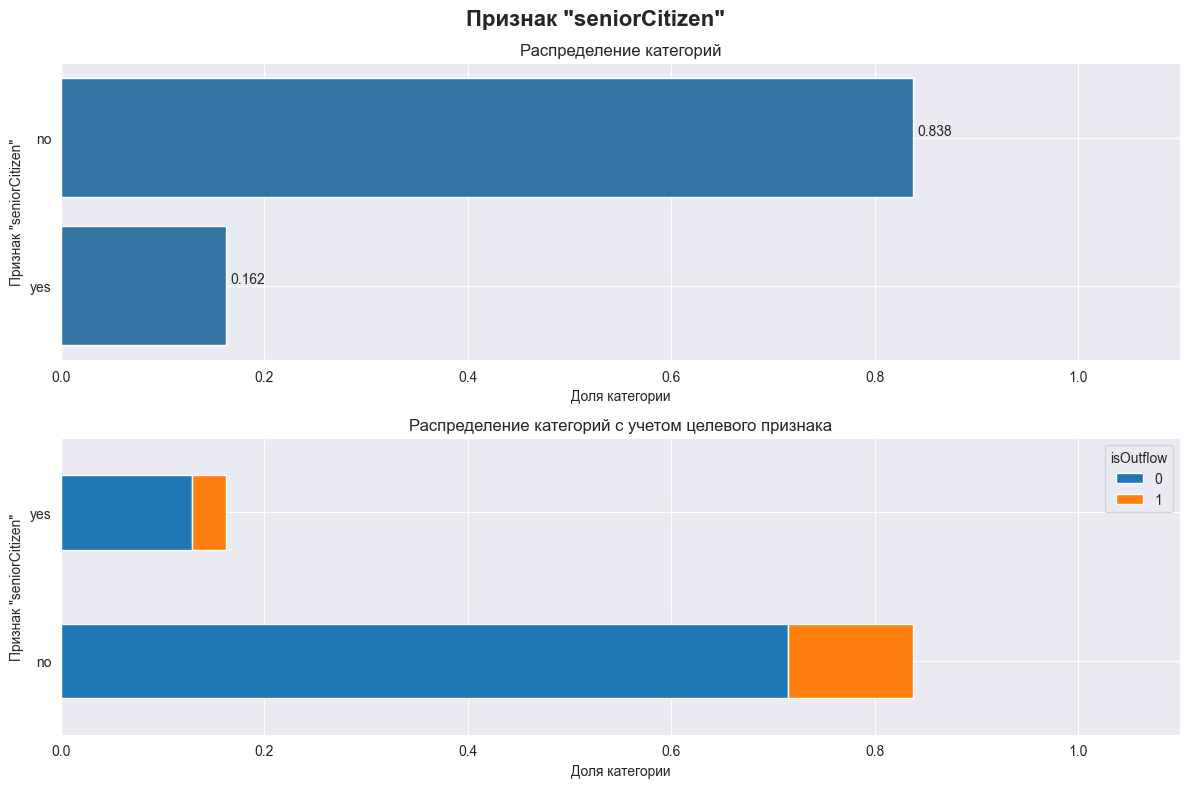

,seniorCitizen,isOutflow,count,persent
0,no,0,5032,85.27
2,no,1,869,14.73
1,yes,0,910,79.68
3,yes,1,232,20.32


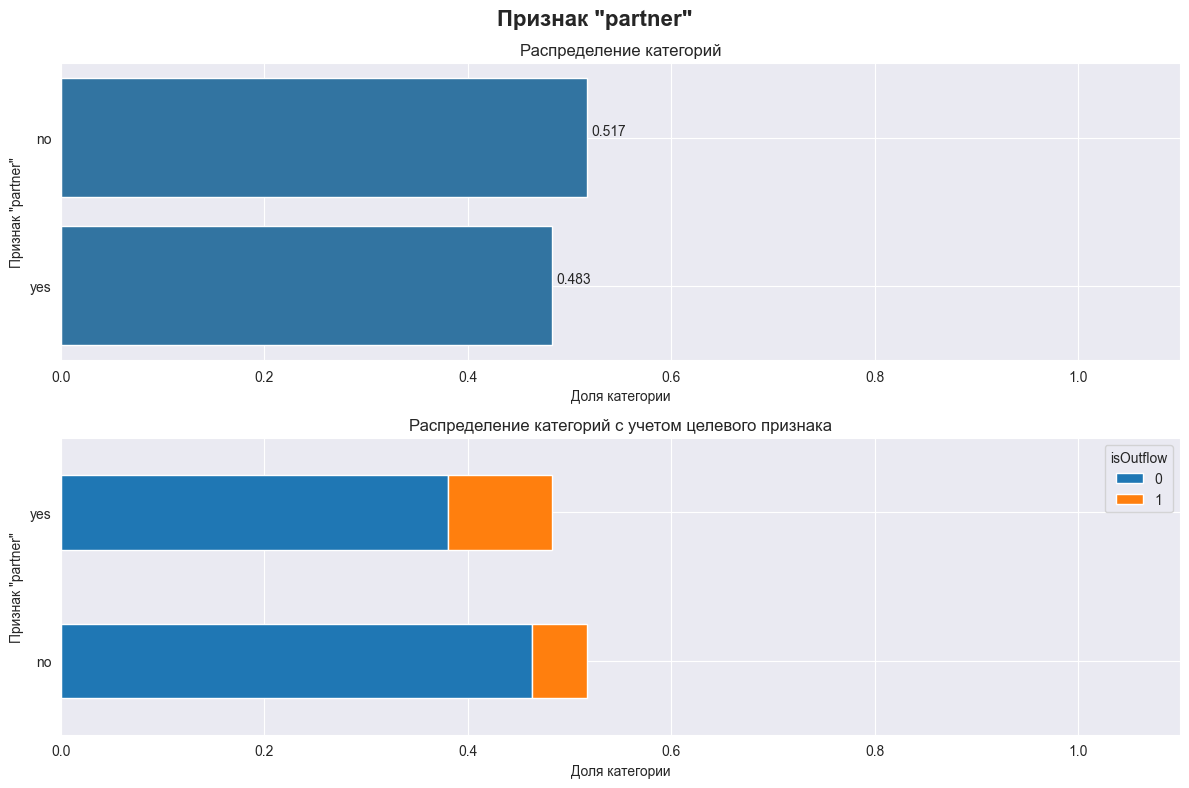

,partner,isOutflow,count,persent
0,no,0,3259,89.51
3,no,1,382,10.49
1,yes,0,2683,78.87
2,yes,1,719,21.13


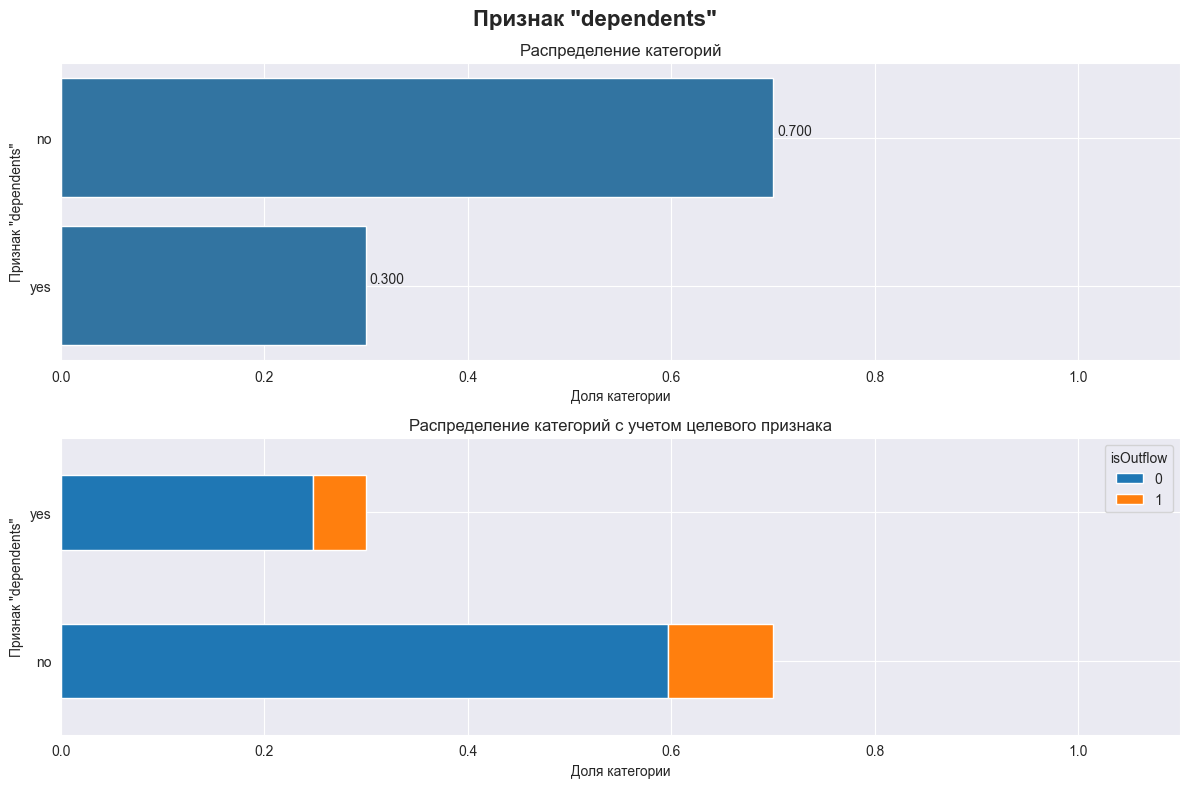

,dependents,isOutflow,count,persent
0,no,0,4200,85.14
2,no,1,733,14.86
1,yes,0,1742,82.56
3,yes,1,368,17.44


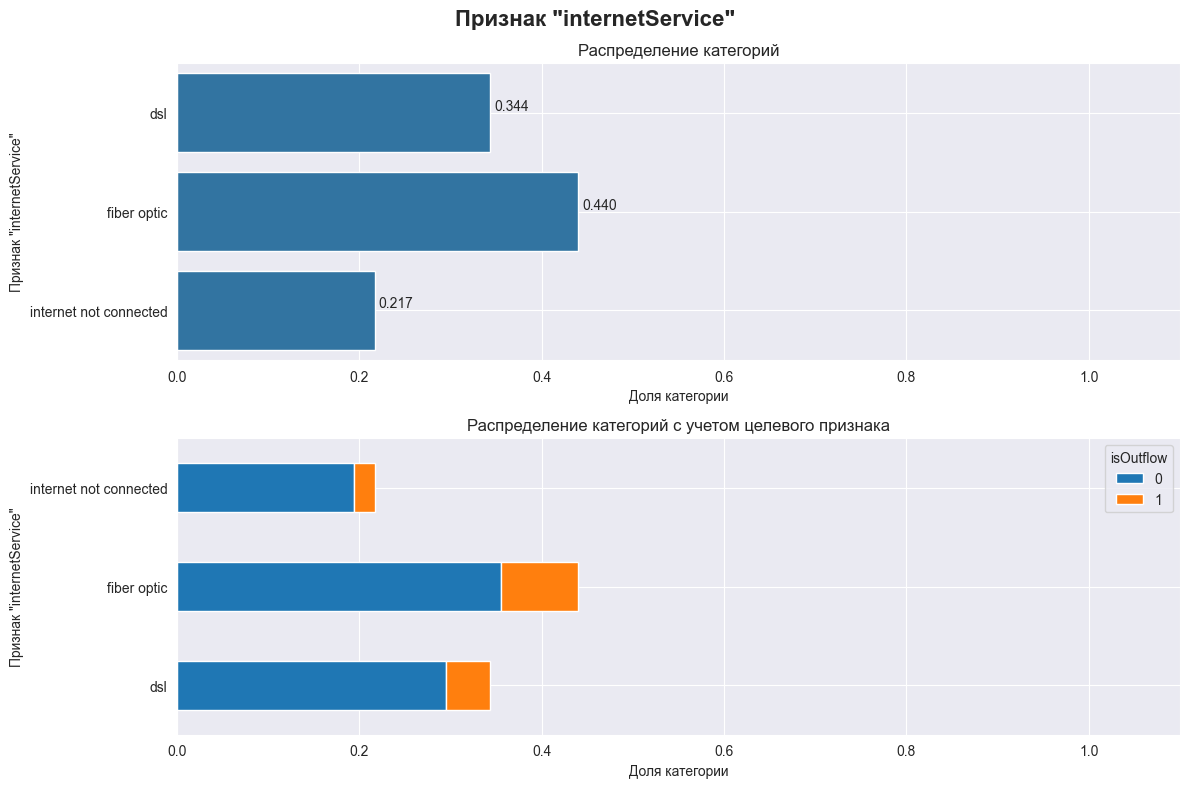

,internetService,isOutflow,count,persent
1,dsl,0,2075,85.71
4,dsl,1,346,14.29
0,fiber optic,0,2501,80.78
3,fiber optic,1,595,19.22
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


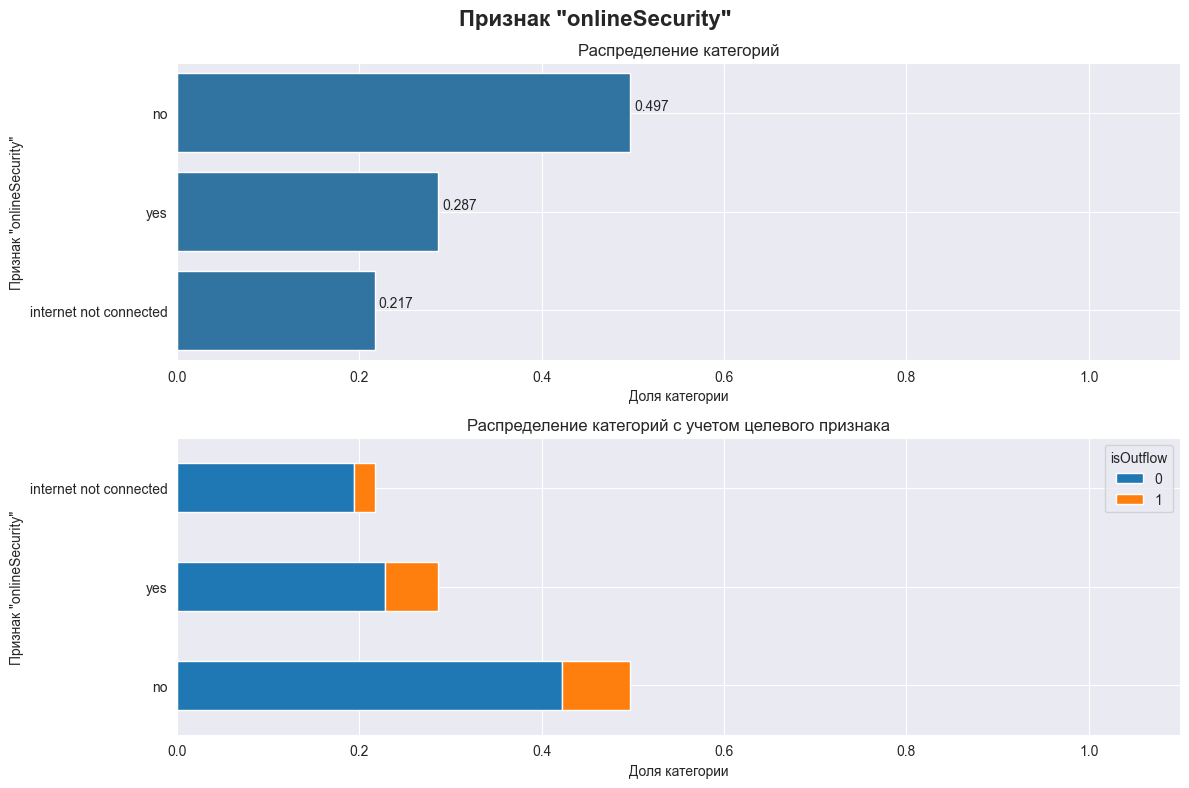

,onlineSecurity,isOutflow,count,persent
0,no,0,2972,84.96
3,no,1,526,15.04
1,yes,0,1604,79.45
4,yes,1,415,20.55
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


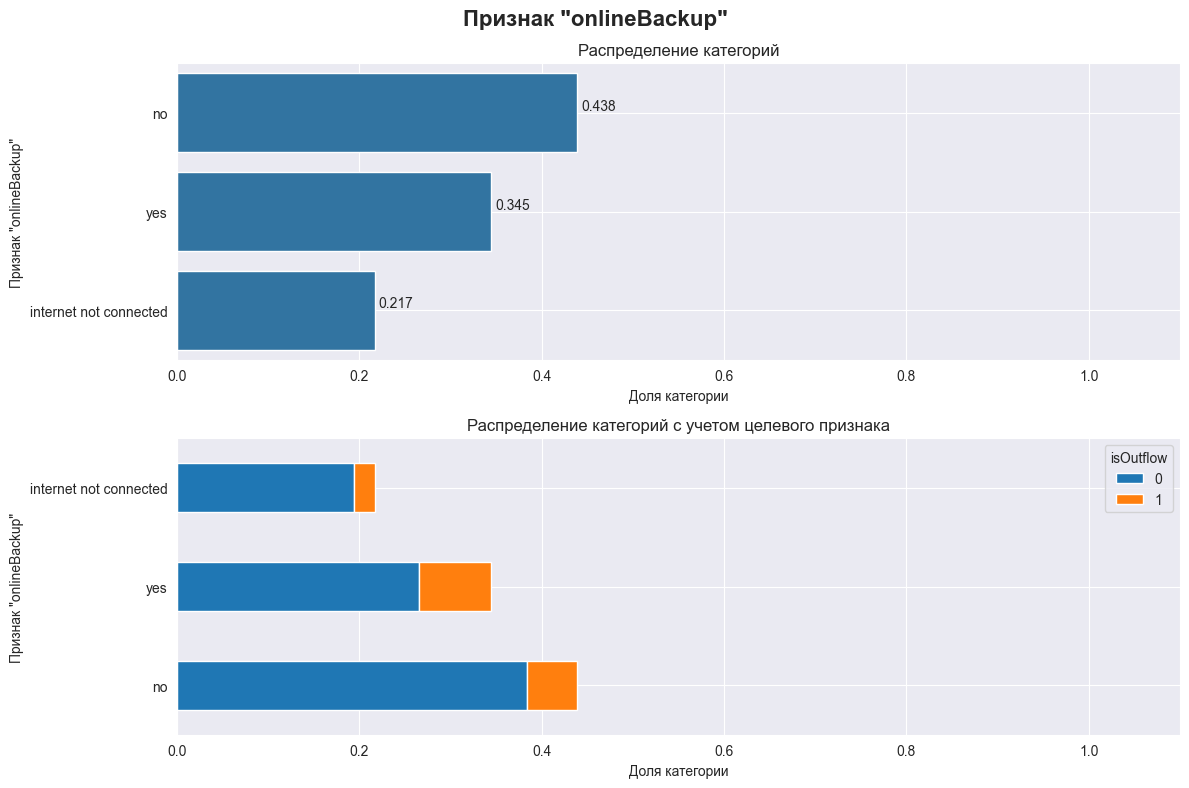

,onlineBackup,isOutflow,count,persent
0,no,0,2707,87.66
4,no,1,381,12.34
1,yes,0,1869,76.95
3,yes,1,560,23.05
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


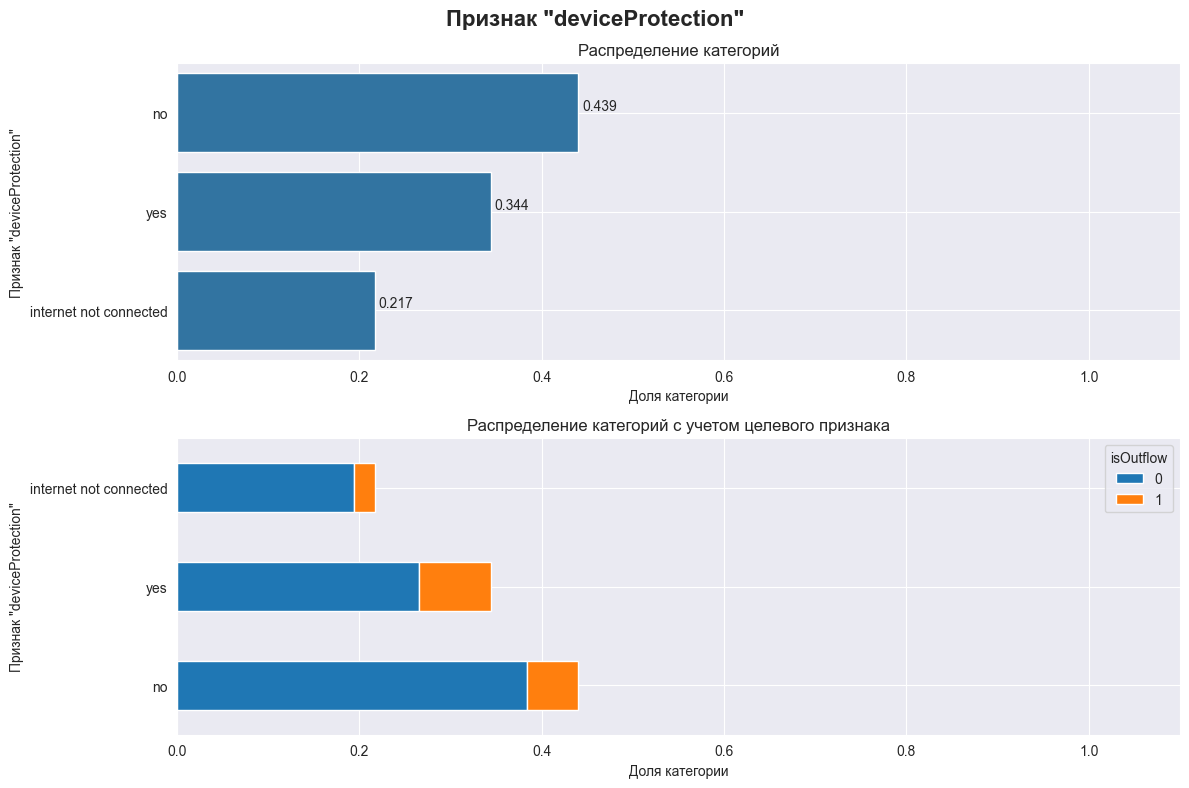

,deviceProtection,isOutflow,count,persent
0,no,0,2704,87.37
4,no,1,391,12.63
1,yes,0,1872,77.29
3,yes,1,550,22.71
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


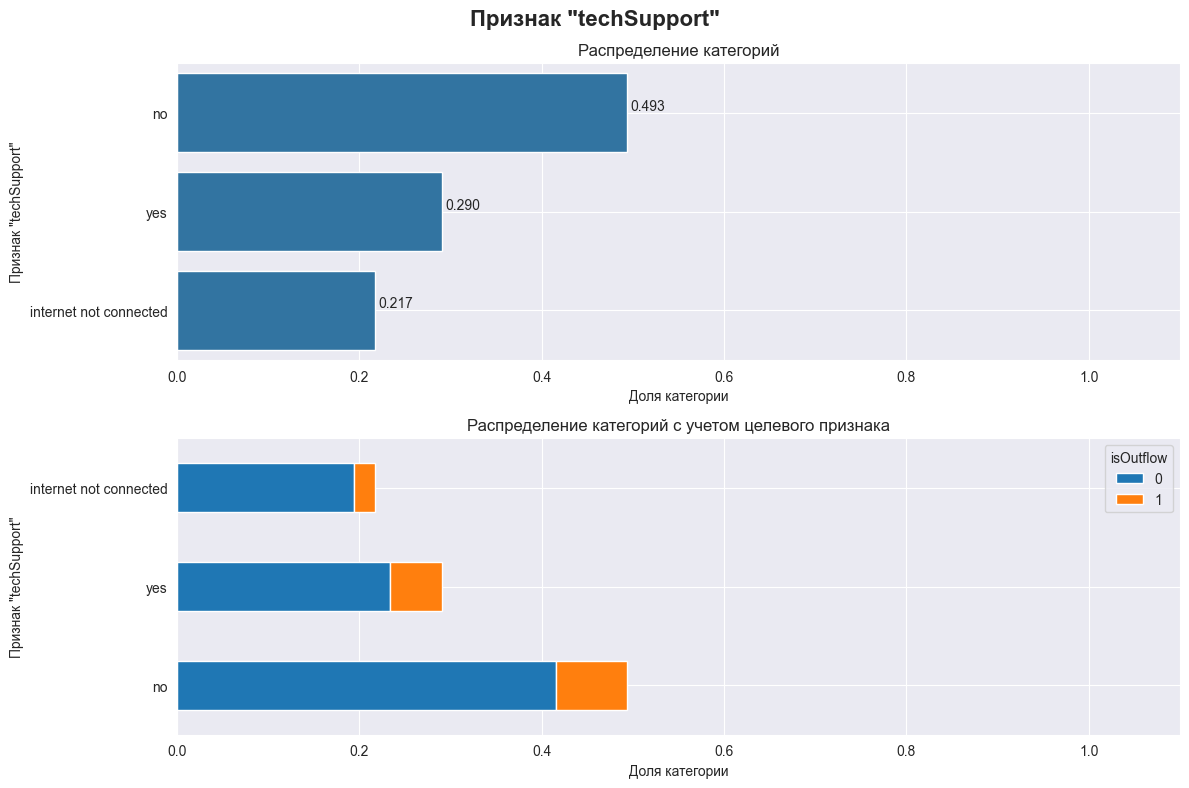

,techSupport,isOutflow,count,persent
0,no,0,2930,84.37
3,no,1,543,15.63
1,yes,0,1646,80.53
4,yes,1,398,19.47
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


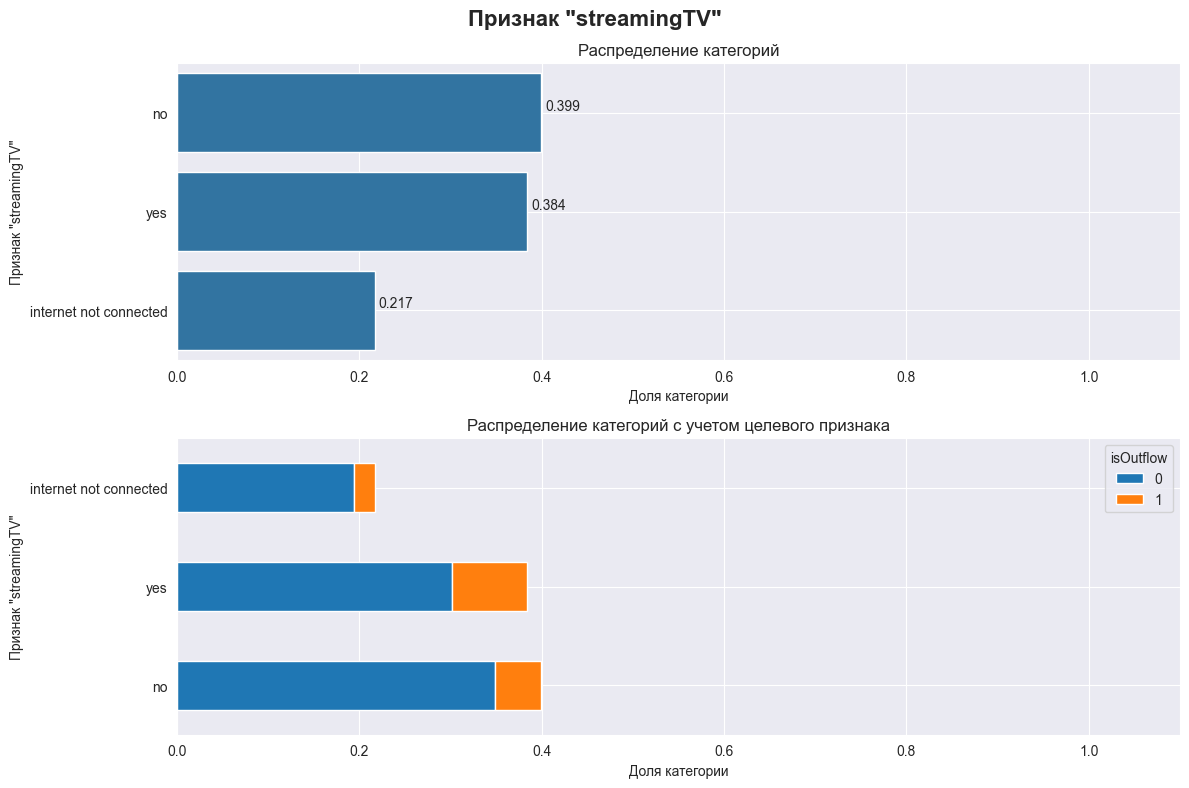

,streamingTV,isOutflow,count,persent
0,no,0,2453,87.30
4,no,1,357,12.70
1,yes,0,2123,78.43
3,yes,1,584,21.57
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


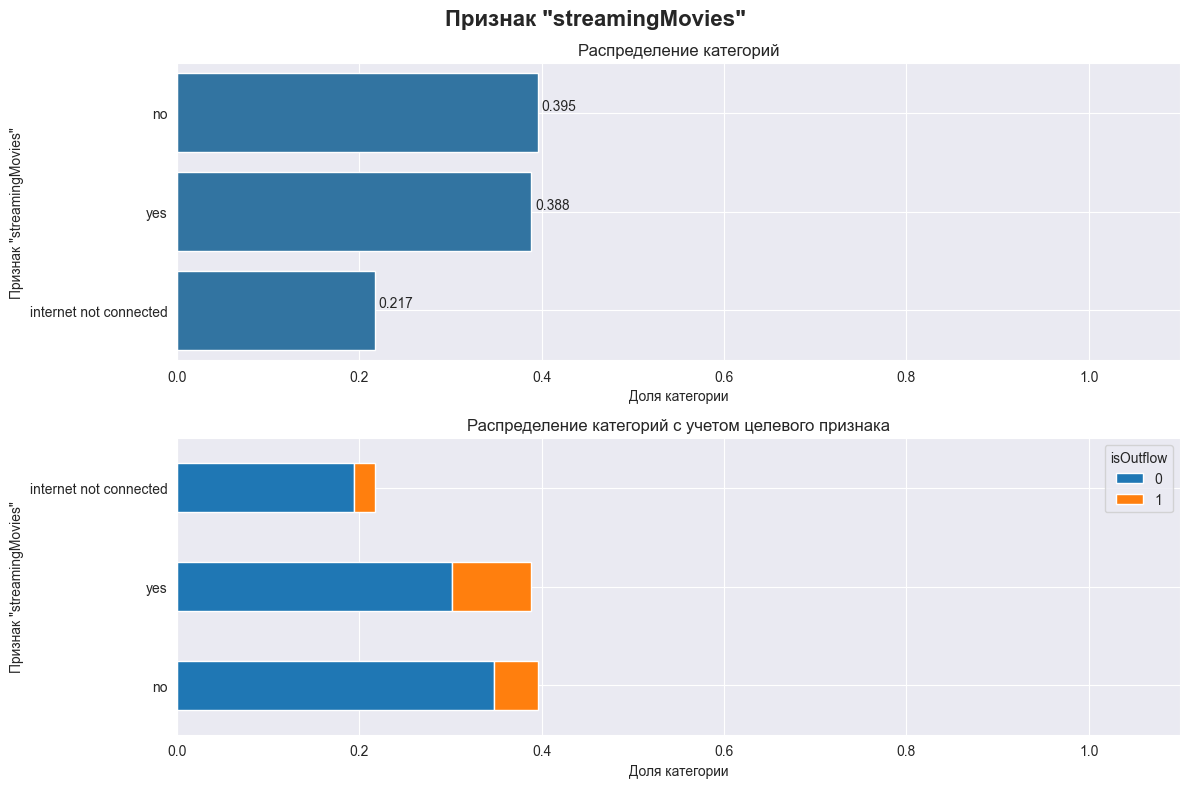

,streamingMovies,isOutflow,count,persent
0,no,0,2450,87.97
4,no,1,335,12.03
1,yes,0,2126,77.82
3,yes,1,606,22.18
2,internet not connected,0,1366,89.52
5,internet not connected,1,160,10.48


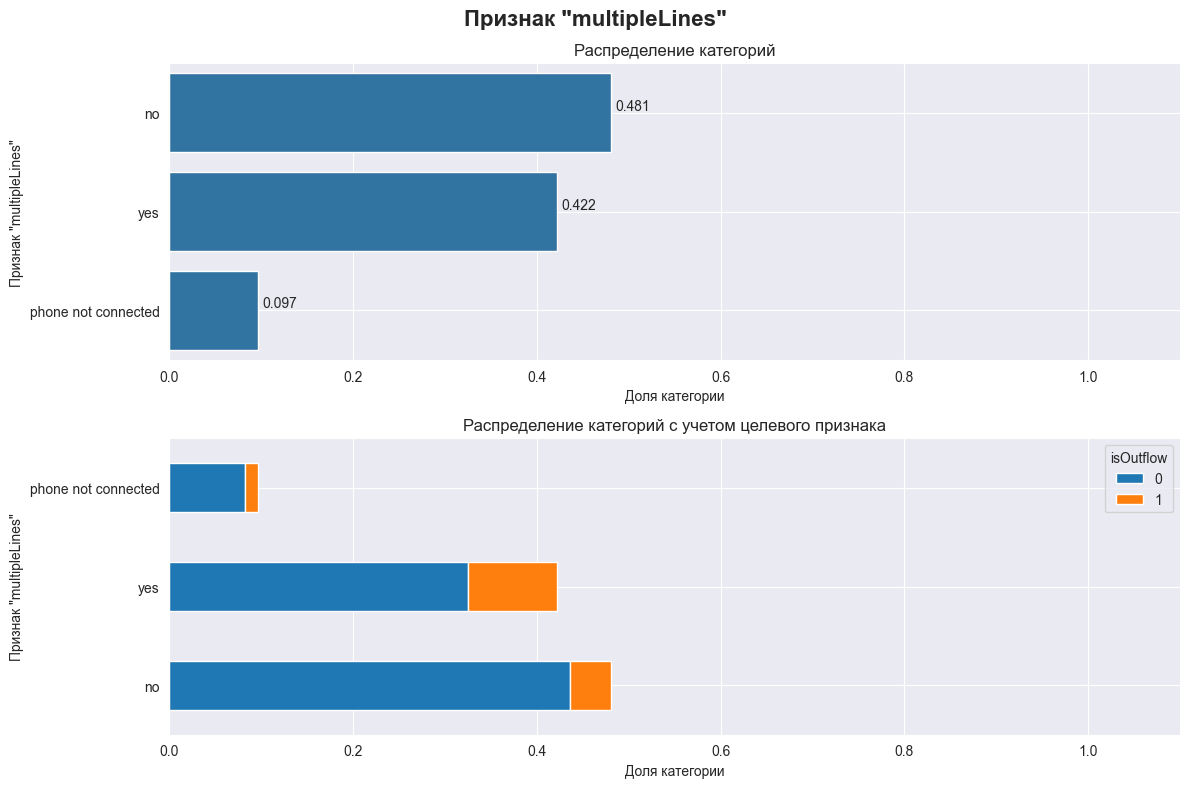

,multipleLines,isOutflow,count,persent
0,no,0,3070,90.56
4,no,1,320,9.44
1,yes,0,2293,77.18
2,yes,1,678,22.82
3,phone not connected,0,579,84.90
5,phone not connected,1,103,15.10


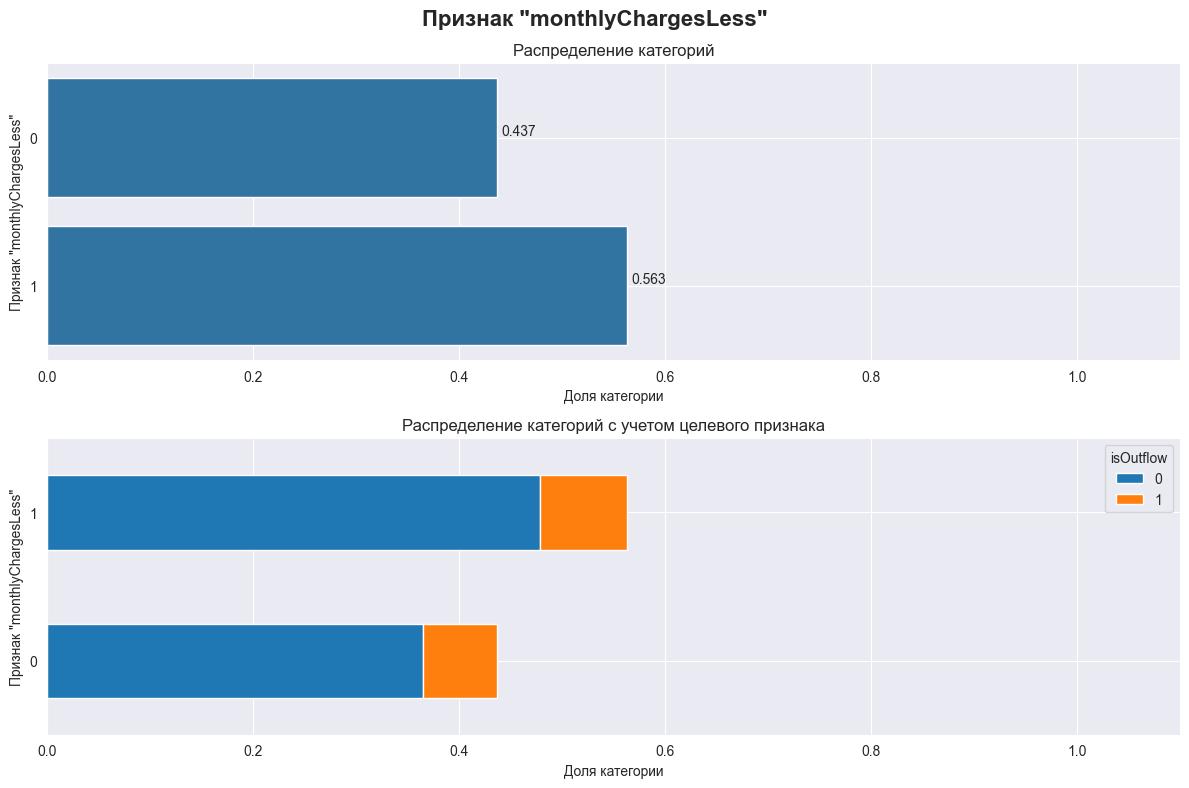

,monthlyChargesLess,isOutflow,count,persent
1,0,0,2569,83.49
3,0,1,508,16.51
0,1,0,3373,85.05
2,1,1,593,14.95


Корреляция Крамера для категориальных признаков


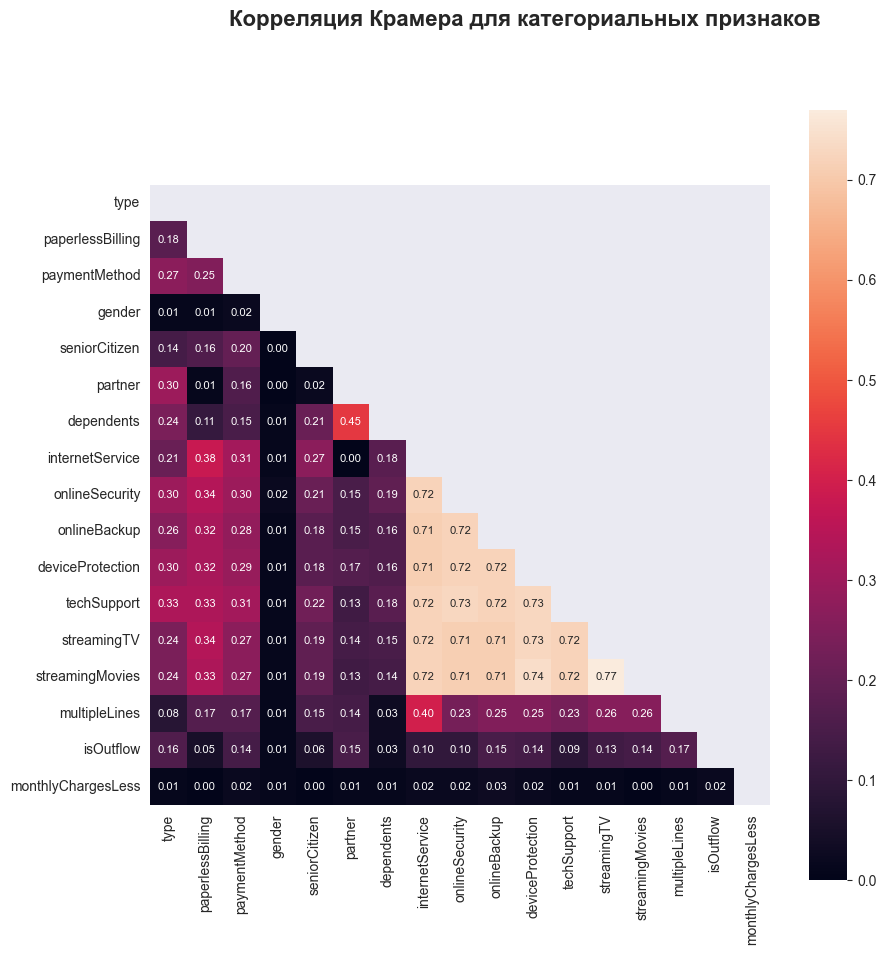


Временные признаки
--------------------
В таблице нет временных признаков

Коэффициент взаимной информации всех признаков


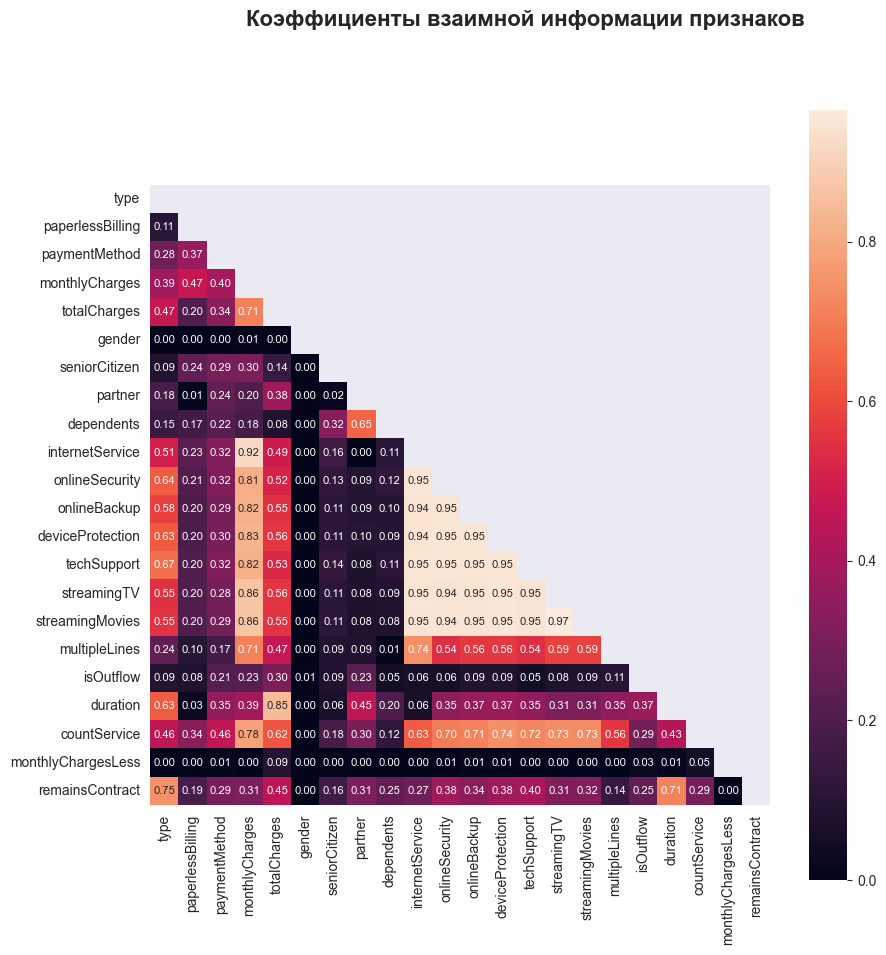

----------------------------------------------------------------------


In [51]:
create_eda_dataset(
    df_merge.drop(['customerId', 'beginDate', 'endDate'], axis=1),
    name_dataset='Объединенный датасет',
    target='isOutflow'
)

**Вывод:**  
В датасете наблюдается сильный дисбаланс классов:
* 0 - `84.4%`
* 1 - `15.6%`  
  
Связь целевого признака с другими:
* `monthlyCharges` - расходы за месяц  
Наблюдается увеличение оттока клиентов с увеличение расходов за месяц.

* `totalCharges` — общие расходы абонента
Наблюдается увеличенный отток клиентов на меньших суммах общих расходов. Однако это может быть связано не с суммой расходов, а с тем, что эти клиенты меньше по времени пользуются услугами компании.

* `duration`- длительность пользования ислугами в месяцах  
Распределение длительности пользованием услугами напоминает экспоненциальное. При этом распределение длительности пользование услугами ушедших клиентов напоминает нормальное распределение с вершиной в районе 30-40 месяцев

* `countService` - количество полключенных услуг  
Распеределение количества подключенных доп услуг напоминает экспоненциальное. Можно заметить, что клиенты с 0,1,2 подключенными услугами уходят чуть реже остальных. Возможно, это связано с тем, что большое количество услуг сильно бьет по кошельку клиентов

* `remainsContract` - какая доля оплаченного договора остается в запасе
Большой всплеск значений около 0 связан с тем, что большинство клиентов пользуются помесячной оплатой. Признак не выглядит информативным.

* `type` — тип оплаты
Удивительно, но оказалось, что клиенты с помесячной оплатой уходят в 2 раза меньше, чем клиенты с оплатой раз в один или два года. Возможно, это связано с тем, что клиенту необходимо единоразово заплатить большую сумму.

* `paperlessBilling` — электронный расчётный лист
Люди, который используют электронный расчетный лист уходят чуть чаще, чем остпльные абоненты (`17.29%` против `13.23%`).

* `paymentMethod` — тип платежа;
Реже всего уходят клиенты, которые получаеют чек на почту - `7.26%`. Чуть чаще уходят клиенты, которые получают эдектронный чек - `14.8%`. А вот клиенты, у которых подключен автоматический платеж, уходят уже более чем в `20%` случаев

* `gender` — пол
Не наблюдается зависимости оттока клиентов от гендерной принадлежности

* `seniorCitizen` — является ли абонент пенсионером
Пенсионеры уходят чаще других абонентов (в `20.32%` случаев против `14.73%`)

* `partner` — есть ли у абонента супруг или супруга
Клиенты, у которых есть супруг(а) уходят в 2 раза чаще холостых абонентов (`21.12%` против `10.49`)

* `dependents` — есть ли у абонента дети
Абоненты с детьми уходят чуть чаще абонентов без детей (`17.44%` против `14.86%`)

* `internetService` — тип подключения
Абоненты с типом подключения `dsl` уходят чуть реже, чем абоненты с типом подключения `fiber optic` (`14.29%` против `19.22%`)

* `onlineSecurity` — блокировка опасных сайтов
Абоненты с подключенной услугой блокировки опасных сайтов уходят аж в `20.55%` случаев. При этом абоненты без данной услуги уходят в `15.04%` случаев

* `onlineBackup` — облачное хранилище файлов для резервного копирования данных
Абоненты с подключенной услугой облачного хранилища уходят аж в `23.05%` случаев. При этом абоненты без данной услуги уходят в `12.34%` случаев

* `deviceProtection` — антивирус
Абоненты с подключенной услугой антивируса уходят аж в `22.71%` случаев. При этом абоненты без данной услуги уходят в `12.63%` случаев

* `techSupport` — выделенная линия технической поддержки
Абоненты с подключенной услугой выделенной линии технической поддержки уходят аж в `19.47%` случаев. При этом абоненты без данной услуги уходят в `15.63%` случаев

* `streamingTV` — стриминговое телевидение
Абоненты с подключенной услугой выделенной линии технической поддержки уходят аж в `21.57%` случаев. При этом абоненты без данной услуги уходят в `12.70%` случаев

* `streamingMovies` — каталог фильмов
Абоненты с подключенной услугой выделенной линии технической поддержки уходят аж в `22.18%` случаев. При этом абоненты без данной услуги уходят в `12.03%` случаев

* `multipleLines` — подключение телефона к нескольким линиям одновременно.
Абоненты с подключенной услугой выделенной линии технической поддержки уходят аж в `22.82%` случаев. При этом абоненты без данной услуги уходят в `9.44%` случаев

* `monthlyChargesLess` - бинарный признак, являются ли затраты абонента за последний месяц меньше его среднемесячных затрат
Клиенты, у которых месячные затраты меньше среднемесячных затрах уходят в `14.95%`, у которых больше в `16.51%`.

Корреляционный анализ  
По матрице корреляции видно, что признаки `totalCharges`, `internetService` `onlineSecurity`, `onlineBackup`, `deviceProtection`, `techSupport` `streamingTV`, `streamingMovies` сильно коррелируют между собой. Также можно заметить, что признаки `gender`, `monthlyChargesLess`, никак не коррелирую с целевым признаком. 

## Выбор модели

In [52]:
def selection_model_params(model, params, features, target, metric, cv=5, n_jobs=-1):
    gscv = GridSearchCV(
        model, params, cv=cv,
        scoring=metric,
        refit=False,
        return_train_score=True,
        verbose=3,
        n_jobs=n_jobs
    )
    gscv.fit(features, target)
    return pd.DataFrame(gscv.cv_results_).sort_values(
        by='mean_test_score', ascending=False
    )

In [53]:
features = df_merge.drop([
    'customerId', 'beginDate', 'endDate',
    'totalCharges', 'gender',
    'internetService', 'onlineSecurity',
    'onlineBackup', 'deviceProtection', 'techSupport',
    'streamingTV', 'streamingMovies',
    'monthlyChargesLess',
    'isOutflow'
], axis=1)
target = df_merge['isOutflow']

In [54]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, stratify=target, random_state=RANDOM_STATE
)

In [55]:
numerics = features.select_dtypes(include='number').columns.to_list()
categorical = features.select_dtypes(include='category').columns.to_list()

col_transformer_linear = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerics),
        ('ohe', OneHotEncoder(sparse_output=False, drop='first'), categorical)
    ], remainder="passthrough"
)

col_transformer_tree = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerics),
        ('ordinal', OrdinalEncoder(), categorical)
    ], remainder="passthrough"
)

col_transformer_catboost = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerics)
    ], remainder="passthrough"
)

col_transformer_linear.set_output(transform='pandas')
col_transformer_tree.set_output(transform='pandas')
col_transformer_catboost.set_output(transform='pandas')

col_transformer_linear.fit(features_train)
col_transformer_tree.fit(features_train)
col_transformer_catboost.fit(features_train)
!

In [56]:
features_train_linear = col_transformer_linear.transform(features_train)
features_test_linear = col_transformer_linear.transform(features_test)

features_train_tree = col_transformer_tree.transform(features_train)
features_test_tree = col_transformer_tree.transform(features_test)

features_train_catboost = col_transformer_catboost.transform(features_train)
features_test_catboost = col_transformer_catboost.transform(features_test)

In [57]:
if IS_SELECTION_PARAMETERS:
    model_log_regression = LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        log_reg_best_param_df = selection_model_params(
            model_log_regression, GSCV_LOG_REGRESSION_CONFIG,
            features_train_linear, target_train, 'roc_auc'
        )
    log_reg_best_param_df.to_csv('results/log_reg_best_param.csv', index=False)
elif IS_LOCAL:
    log_reg_best_param_df = pd.read_csv(
        'results/log_reg_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"').replace('None', 'null'))
        }
    )

if IS_LOCAL:
    log_reg_best_param = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('params')]
    log_reg_mean_train_score = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('mean_train_score')]
    log_reg_mean_test_score = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('mean_test_score')]
else:
    log_reg_best_param = {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
    log_reg_mean_train_score = 0.76
    log_reg_mean_test_score = 0.75
print(f'''train_score = {log_reg_mean_train_score:.2f}
test_score={log_reg_mean_test_score:.2f}
best_param: {log_reg_best_param}''')

train_score = 0.75
test_score=0.74
best_param: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [58]:
if IS_SELECTION_PARAMETERS:
    model_random_forest = RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        random_forest_best_param_df = selection_model_params(
            model_random_forest, GSCV_RAND_FOREST_CONFIG,
            features_train_tree, target_train, 'roc_auc'
        )
    random_forest_best_param_df.to_csv('results/random_forest_best_param.csv', index=False)
elif IS_LOCAL:
    random_forest_best_param_df = pd.read_csv(
        'results/random_forest_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"').replace('None', 'null'))
        }
    )

if IS_LOCAL:
    random_forest_best_param = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('params')
    ]
    random_forest_mean_train_score = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_train_score')
    ]
    random_forest_mean_test_score = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    random_forest_best_param = {'max_depth': 5, 'n_estimators': 81}
    random_forest_mean_train_score = 0.85
    random_forest_mean_test_score = 0.82
print(f'''train_score = {random_forest_mean_train_score:.2f}
test_score={random_forest_mean_test_score:.2f}
best_param: {random_forest_best_param}''')

train_score = 0.86
test_score=0.82
best_param: {'max_depth': 5, 'n_estimators': 201}


In [59]:
features_test_catboost

,scaler__monthlyCharges,scaler__duration,scaler__countService,scaler__remainsContract,remainder__type,remainder__paperlessBilling,remainder__paymentMethod,remainder__seniorCitizen,remainder__partner,remainder__dependents,remainder__multipleLines
1182,-0.373433,1.225442,0.755887,-0.671638,month-to-month,yes,electronic check,no,no,no,phone not connected
1873,0.190896,-0.513523,0.755887,-0.008165,two year,yes,credit card (automatic),no,yes,yes,no
3559,-1.505429,-0.112223,-1.205354,1.982257,two year,no,credit card (automatic),no,no,no,no
2272,-0.503662,-1.271533,-0.715043,-0.671638,month-to-month,yes,electronic check,no,no,yes,no
5584,0.519809,-0.781056,-0.224733,-0.671638,month-to-month,yes,bank transfer (automatic),no,yes,no,yes
...,...,...,...,...,...,...,...,...,...,...,...
1461,1.034049,-0.335168,0.755887,-0.671638,month-to-month,no,credit card (automatic),no,yes,no,yes
2668,-1.508768,-1.093178,-1.205354,-0.671638,month-to-month,no,mailed check,no,no,yes,no
5761,-0.852611,0.824142,0.265577,2.380341,two year,no,mailed check,no,yes,yes,phone not connected
5745,-1.360173,1.403797,-0.715043,0.655309,two year,yes,mailed check,no,yes,yes,yes


In [60]:
if IS_SELECTION_PARAMETERS:
    task_type = 'GPU' if get_gpu_device_count() else 'CPU'
    model_cat_boost = CatBoostClassifier(
        random_state=RANDOM_STATE, task_type=task_type,
        cat_features=features_test_catboost.select_dtypes(include='category').columns.to_list()
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cat_boost_best_param_df = selection_model_params(
            model_cat_boost, GSCV_CAT_BOOSRT_CONFIG,
            features_train_catboost, target_train,
            'roc_auc', cv=5, n_jobs=8
        )
    cat_boost_best_param_df.to_csv('results/cat_boost_best_param.csv', index=False)
elif IS_LOCAL:
    cat_boost_best_param_df = pd.read_csv(
        'results/cat_boost_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"').replace('None', 'null'))
        }
    )

if IS_LOCAL:
    cat_boost_best_param = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('params')
    ]
    cat_boost_mean_train_score = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('mean_train_score')
    ]
    cat_boost_mean_test_score = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    cat_boost_best_param = {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}
    cat_boost_mean_train_score = 0.80
    cat_boost_mean_test_score = 0.66
print(f'''train_score = {cat_boost_mean_train_score:.2f}
test_score={cat_boost_mean_test_score:.2f}
best_param: {cat_boost_best_param}''')

train_score = 0.86
test_score=0.83
best_param: {'learning_rate': 0.1, 'max_depth': 2}


Нейронная сеть

In [61]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [62]:
class NNClassifier(nn.Module):
    def __init__(self, input_size ):
        super(NNClassifier, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers_stack(x)

In [63]:
def fit(
    model, X, y, device,
    learning_rate=.001, num_epoch=100, 
    min_loss_delta=.001, max_counter=30
):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.2, stratify=y, random_state=RANDOM_STATE)
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_valid = torch.FloatTensor(X_valid).to(device)
    y_valid = torch.FloatTensor(y_valid).to(device)
    model = model.to(device)
    counter = 0 # Cчётчик для ранней остановки обучения
    
    train_losses = []
    valid_losses = []
    schedule_epochs = []
    prev_loss_value = 0
    
    loss = nn.BCELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epoch):
        model.train()
        # Прямой проход
        outputs = model(X_train).flatten()
        loss_value = loss(outputs, y_train)
        # Обратный проход
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        
        if (epoch+1) % 5 == 0 or epoch == num_epoch - 1:
            with torch.no_grad():
                model.eval()
                pred_valid = model(X_valid).flatten()
                loss_value_valid = loss(pred_valid, y_valid)
                train_losses.append(loss_value.item())
                valid_losses.append(loss_value_valid.item())
                schedule_epochs.append(epoch)
                roc_auc_train = roc_auc_score(y_valid, outputs.detach().numpy())
                roc_auc_valid = roc_auc_score(y_valid, pred_valid.detach().numpy())
                print((f'Эпоха №{epoch+1}. BCE_train: {loss_value:.2f}. BCE_valid: {loss_value_valid:.2f}\n'
                       f'ROC_AUC_train: {roc_auc_train}. ROC_AUC_valid: {roc_auc_valid}'))
        
        delta = torch.abs(prev_loss_value - loss_value).item()
        if delta < min_loss_delta:
            counter += 1
            if counter > max_counter:
                print('Ранняя остановка')
                break
        else:
            counter = 0
        prev_loss_value = loss_value
    df_schedule = pd.DataFrame({'train': train_losses, 'valid': valid_losses, 'epoch': schedule_epochs})
    df_schedule.plot(
        x='epoch', figsize=(12, 4), grid=True,
        title=f'Качество НС в зависимости от эпохи',
        ylabel='RMSE', xlabel='Эпоха' 
    )

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, AUC

In [99]:
def create_model(input_shape):
    model = Sequential([
        Dense(16, input_dim=input_shape, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=[AUC(name='auc'), BinaryAccuracy(name='acc')]
    )
    return model


def train_model(model, features, target,
                batch_size=32, epochs=10,
                steps_per_epochs=None, validation_steps=None):
    
    features_train, features_valid, target_train, target_valid = train_data
    history = model.fit(
        features_train, target_train,
        validation_data=(features_test, target_test),
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epochs,
        validation_steps=validation_steps,
        verbose=2, shuffle=True
    )
    fig = plt.figure(figsize=(12,8))
    ax_1 = fig.add_subplot(2,1,1)
    ax_1.plot(history.history['auc'])
    ax_1.plot(history.history['val_auc'])
    ax_1.set_title('model ROC-AUC')
    ax_1.set_ylabel('accuracy')
    ax_1.axes.xaxis.set_visible(False)
    ax_1.legend(['train', 'val'], loc='upper left')
    
    ax_2 = fig.add_subplot(2,1,2)
    ax_2.plot(history.history['loss'])
    ax_2.plot(history.history['val_loss'])
    ax_2.set_title('model loss')
    ax_2.set_ylabel('loss')
    ax_2.set_xlabel('epoch')
    ax_2.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return model

Epoch 1/10
166/166 - 5s - 31ms/step - acc: 0.8207 - auc: 0.5538 - loss: 0.4952 - val_acc: 0.8438 - val_auc: 0.7279 - val_loss: 0.3910
Epoch 2/10
166/166 - 1s - 6ms/step - acc: 0.8474 - auc: 0.7280 - loss: 0.3863 - val_acc: 0.8495 - val_auc: 0.7847 - val_loss: 0.3610
Epoch 3/10
166/166 - 1s - 6ms/step - acc: 0.8565 - auc: 0.7720 - loss: 0.3647 - val_acc: 0.8648 - val_auc: 0.8124 - val_loss: 0.3428
Epoch 4/10
166/166 - 1s - 6ms/step - acc: 0.8576 - auc: 0.7962 - loss: 0.3516 - val_acc: 0.8660 - val_auc: 0.8258 - val_loss: 0.3342
Epoch 5/10
166/166 - 1s - 6ms/step - acc: 0.8576 - auc: 0.8088 - loss: 0.3446 - val_acc: 0.8648 - val_auc: 0.8298 - val_loss: 0.3300
Epoch 6/10
166/166 - 1s - 6ms/step - acc: 0.8580 - auc: 0.8146 - loss: 0.3404 - val_acc: 0.8677 - val_auc: 0.8332 - val_loss: 0.3264
Epoch 7/10
166/166 - 1s - 7ms/step - acc: 0.8603 - auc: 0.8173 - loss: 0.3376 - val_acc: 0.8660 - val_auc: 0.8370 - val_loss: 0.3243
Epoch 8/10
166/166 - 1s - 7ms/step - acc: 0.8607 - auc: 0.8213 - los

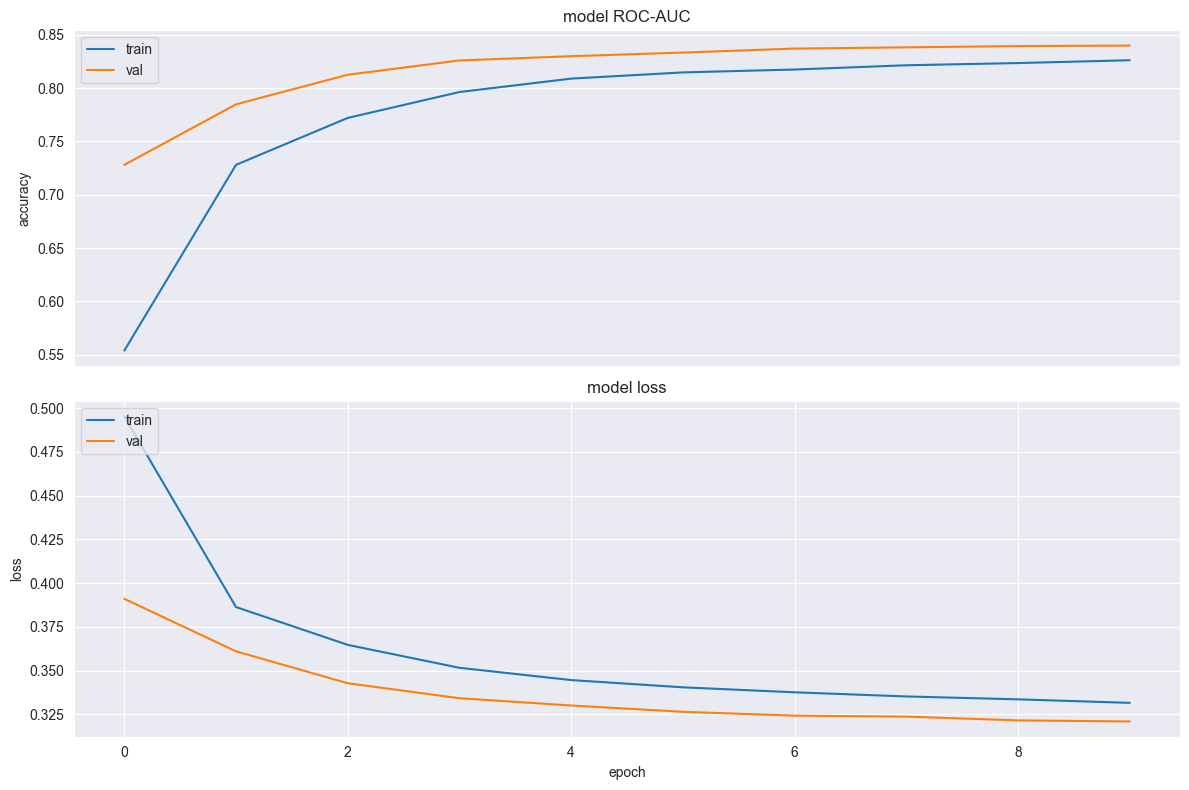

In [100]:
model = create_model(features_train_linear.shape[1])
model = train_model(
    model,
    (features_train_linear.to_numpy(), target_train.to_numpy()),
    (features_test_linear.to_numpy(), target_test.to_numpy())
)

In [ ]:
# Генерация случайных данных для примера
# X - входные данные (например, 100 образцов с 20 признаками)
# y - метки классов (0 или 1)
np.random.seed(42)
X = np.random.rand(100, 20)
y = np.random.randint(0, 2, 100)

# Создание модели
model = Sequential()

# Добавление слоев
# Первый скрытый слой с 16 нейронами и функцией активации ReLU
model.add(Dense(16, input_dim=20, activation='relu'))

# Второй скрытый слой с 8 нейронами и функцией активации ReLU
model.add(Dense(8, activation='relu'))

# Выходной слой с 1 нейроном и сигмоидной функцией активации
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer=,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

# Обучение модели
model.fit(X, y, epochs=50, batch_size=10, verbose=1)

# Оценка модели
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')